# **TUIA - Aprendizaje Automático 1 - 2024**

---

**Trabajo Práctico Integrador** - "Predicción de lluvia en Australia"

**Alumnos:**  

*   Gustavo Fontana
*   Brisa Menescaldi

## **Librerías**

In [ ]:
!pip install shap
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 3.5 MB/s eta 0:00:00


In [ ]:
#from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import shap
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode
import warnings
import gdown

## **Cargado de datos**

**Este set de datos contiene alrededor de 10 años de observaciones meteorológicas diarias en diferentes localizaciones de Australia.**

**El objetivo es la predicción de las columnas 'RainTomorrow' y 'RainfallTomorrow' en función del resto de las características que se consideren adecuadas.**

In [ ]:
# LINK DEL DATASET
url = 'https://drive.google.com/drive/folders/1B8mJ5JZo_x-p7zCKY3ur_xVgFn8M_amY?usp=drive_link'

# DESCARGAR Y GUARDAR EN EL ENTORNO
gdown.download_folder(url, quiet=True, output='DATASET')

#uploaded = files.upload()

['DATASET/weatherAUS.csv']

In [ ]:
data = pd.read_csv('/content/DATASET/weatherAUS.csv')
data.head(1)

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0


## **Exploración de los datos**

In [ ]:
# SELECCIONAR LAS CIUDADES DE INTERES
ciudades = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor' , 'Melbourne',
            'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']
data.query('Location.isin(@ciudades)',inplace=True)

# ELIMINAR LA COLUMNA 0 Y RESETEAR EL INDICE DE PD
data.drop(data.columns[0], axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)

Para el objetivo de las predicciones solo nos quedamos con los registros para nueve localizaciones.

In [ ]:
# TAMAÑO DEL ARCHIVO
print(f'Tamaño del dataset:\n{data.shape[0]} filas - {data.shape[1]} columnas')

Tamaño del dataset:
28233 filas - 24 columnas


In [ ]:
# INFORMACIÓN DEL DATASET
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28233 entries, 0 to 28232
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              28233 non-null  object 
 1   Location          28233 non-null  object 
 2   MinTemp           27663 non-null  float64
 3   MaxTemp           27675 non-null  float64
 4   Rainfall          27247 non-null  float64
 5   Evaporation       23880 non-null  float64
 6   Sunshine          21520 non-null  float64
 7   WindGustDir       26588 non-null  object 
 8   WindGustSpeed     26591 non-null  float64
 9   WindDir9am        26585 non-null  object 
 10  WindDir3pm        27796 non-null  object 
 11  WindSpeed9am      27875 non-null  float64
 12  WindSpeed3pm      27893 non-null  float64
 13  Humidity9am       27293 non-null  float64
 14  Humidity3pm       27343 non-null  float64
 15  Pressure9am       27394 non-null  float64
 16  Pressure3pm       27404 non-null  float6

**El set de datos contiene una combinación de variables categóricas y numéricas.**

*   Las variables categóricas tienen tipo de datos object.

*   Las variables numéricas tienen tipo de datos float64.

*   Además, hay presencia de valores faltantes en el conjunto de datos.


In [ ]:
# VALORES FALTANTES EN EL DATASET
data.isnull().sum()

Date                   0
Location               0
MinTemp              570
MaxTemp              558
Rainfall             986
Evaporation         4353
Sunshine            6713
WindGustDir         1645
WindGustSpeed       1642
WindDir9am          1648
WindDir3pm           437
WindSpeed9am         358
WindSpeed3pm         340
Humidity9am          940
Humidity3pm          890
Pressure9am          839
Pressure3pm          829
Cloud9am            9367
Cloud3pm            9550
Temp9am              585
Temp3pm              576
RainToday            986
RainTomorrow         985
RainfallTomorrow     985
dtype: int64

**El dataset contiene 24 características relevantes con información climática:**

*   Date: fecha de la observación.
*   Location: nombre de las ubicaciones.
*   MinTemp y MaxTemp: valores max. y min. de temperaturas en °C.
*   Rainfall: milímetros de lluvia en el día.
*   Evaportion: mm de evaporación diarias.
*   Sunshine: horas de sol durante el día.
*   WindGustDir: direcciones de las rafagas de viento.
*   WindGustSpeed: velocidad en km/h de las rafagas de viento diarias.
*   WindDir9am/WindDir3pm: direcciones del viento a las 9am y 3pm.
*   WindSpeed9am/WindSpeed3pm: velocidad del viento a las 9am y 3pm.
*   Humidity9am/Humidity3pm: porcentaje de humedad a las 9am y 3pm.
*   Pressure9am/Pressure3pm: presión atmosférica en hpa a las 9am y 3pm.
*   Cloud9am/Cloud3pm: nivel de nubosidad en octales a las 9am y 3pm.
*   Temp9am/Temp3pm: temperatura en °C a las 9am y 3pm.
*   RainToday: booleano 1 si la precipitación supera los 1mm (0 contrario).
*   RainTomorrow: cantidad de lluvia al día siguiente en mm.
*   RainfallTomorrow: booleano 1 si llovio al día siguiente (0 contrario).


In [ ]:
# ANÁLISIS DESCRIPTIVO DE LAS VARIABLES NUMÉRICAS
data.describe().round(1)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,27663.0,27675.0,27247.0,23880.0,21520.0,26591.0,27875.0,27893.0,27293.0,27343.0,27394.0,27404.0,18866.0,18683.0,27648.0,27657.0,27248.0
mean,11.3,21.9,2.1,4.8,6.9,41.8,15.1,20.0,68.8,50.5,1018.2,1016.1,4.7,4.7,15.5,20.4,2.0
std,5.7,6.7,6.4,3.7,3.9,14.2,9.5,9.0,18.7,19.9,7.4,7.3,2.8,2.6,5.7,6.5,6.4
min,-8.0,4.1,0.0,0.0,0.0,9.0,0.0,0.0,5.0,1.0,982.3,984.9,0.0,0.0,-1.3,3.7,0.0
25%,7.4,16.6,0.0,2.2,3.8,31.0,9.0,13.0,57.0,37.0,1013.3,1011.3,1.0,2.0,11.4,15.4,0.0
50%,10.9,21.0,0.0,4.0,7.4,39.0,13.0,19.0,70.0,50.0,1018.4,1016.3,6.0,6.0,15.0,19.5,0.0
75%,15.2,26.2,1.0,6.6,10.0,50.0,20.0,26.0,83.0,64.0,1023.3,1021.1,7.0,7.0,19.1,24.5,1.0
max,33.9,46.8,119.4,86.2,14.3,122.0,69.0,76.0,100.0,100.0,1040.6,1037.9,9.0,8.0,38.6,46.1,119.4


### **Visualización**

Se puede observar el balance de la varable objetivo del problema de clasificación.

Las clases se predicen con la misma probabilidad en modelos donde se encuetran balanceadas.

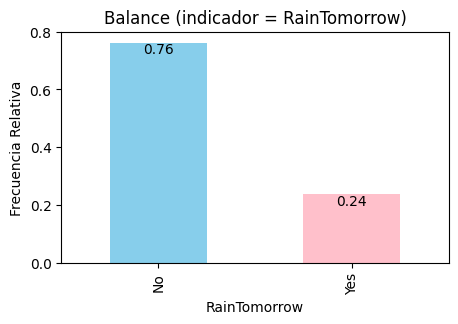

In [ ]:
# GRÁFICO PARA VISUALIZAR EL BALANCE DE 'RainTomorrow'
rel_freq = data['RainTomorrow'].value_counts(normalize=True)

plt.figure(figsize=(5, 3))
grafico = rel_freq.plot(kind='bar', color=['skyblue', 'pink'])

plt.title('Balance (indicador = RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('Frecuencia Relativa')

for index, value in enumerate(rel_freq):
    plt.text(index, value, f'{value:.2f}', ha='center', va='top')

plt.show()

**El número de valores únicos en la variable RainTomorrow es dos, los dos valores únicos son No y Yes.**

**Se observa que existe un desbalance de los datos en un 76/24 con la etiqueta 'NO' como clase mayoritaria.**

*   El NO tiene un total de 20777 entradas

*   El SI tiene un total de 6471 entradas


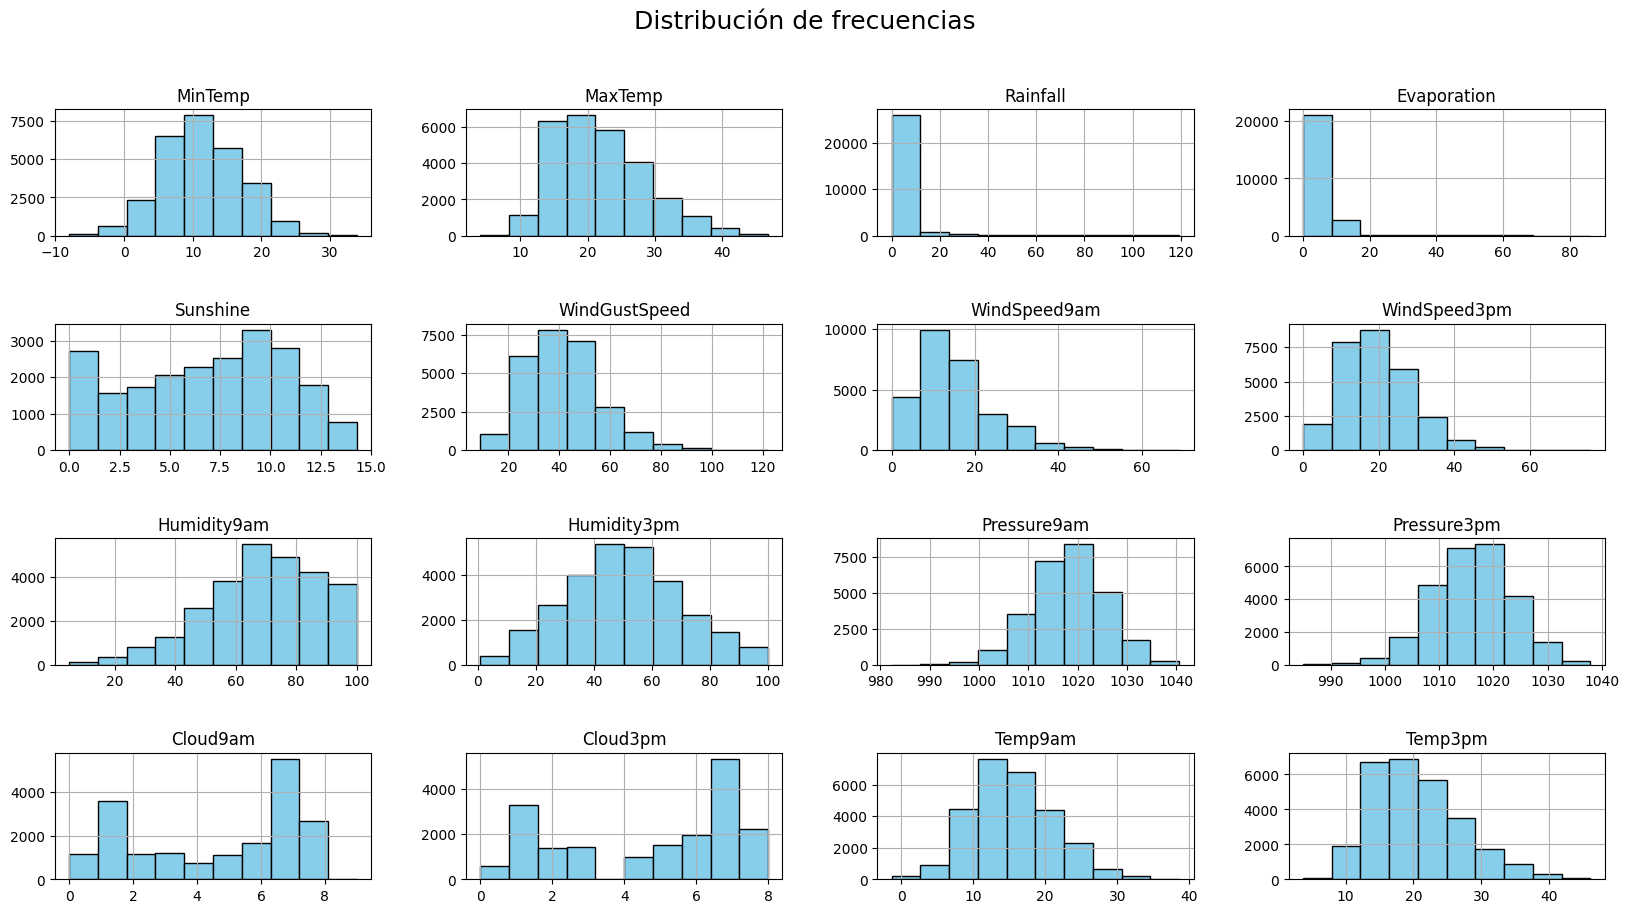

In [ ]:
# HISTOGRAMA DE LOS ATRIBUTOS
data.drop(axis=1,columns='RainfallTomorrow').hist(figsize=(20,10),facecolor='skyblue',bins=10,edgecolor='black')
plt.subplots_adjust(hspace=0.7)
plt.suptitle('Distribución de frecuencias', fontsize=18)
plt.show()

-   Temperaturas (MinTemp, MaxTemp, Temp9am, Temp3pm): Todas estas variables tienen una distribución aproximadamente normal, mostrando que las temperaturas tienden a centrarse alrededor de valores moderados, con pocas ocurrencias de temperaturas extremas.

-   Precipitación y Evaporación (Rainfall, Evaporation): Ambas variables muestran una distribución sesgada a la derecha. La mayoría de los días tienen baja precipitación y evaporación, con pocos días donde estos valores son altos.

-   Viento (WindGustSpeed, WindSpeed9am, WindSpeed3pm): Estas variables también tienen una distribución sesgada a la derecha. La mayoría de los días tienen velocidades de viento bajas a moderadas, con pocas instancias de vientos muy fuertes.

-   Humedad (Humidity9am, Humidity3pm): Las distribuciones de estas variables son aproximadamente normales, lo que sugiere que los niveles de humedad suelen estar en un rango medio, con menos días de humedad muy baja o muy alta.

-   Presión (Pressure9am, Pressure3pm): Ambas variables de presión muestran distribuciones aproximadamente normales centradas alrededor de 1015 hPa, indicando que la presión atmosférica varía poco y se mantiene en un rango estable.

-  Nubosidad (Cloud9am, Cloud3pm): Las distribuciones de la nubosidad son más uniformes y muestran varios picos, indicando una gran variabilidad en la cantidad de nubosidad a lo largo del día.

-   Horas de Sol (Sunshine): La distribución de las horas de sol es uniforme, mostrando una tendencia a una distribución más equitativa de los días soleados.

In [ ]:
# FUNCIÓN PARA GRAFICAR BOXPLOTS
def box_plot(dataset, inf_lim = 0, sup_lim = 0):
  """
  Función para generar boxplots en una misma figura (max. 8).
  Parámetros:
  - dataset: Ruta del set de datos.
  - inf_lim: Limite inferior del slicing.
  - sup_lim: Limite superior del slicing.
  """
  plt.figure(figsize=(16, 8), facecolor='lavender')

  colors = ['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']

  for i, column in enumerate(dataset.select_dtypes(exclude='object').columns[inf_lim:sup_lim]):
      plt.subplot(441 + i)
      sns.boxplot(x=dataset[column], orient='h', color=colors[i])

  plt.subplots_adjust(hspace=0.6, top=0.95)
  plt.suptitle('Distribución de las variables', fontsize=15)
  plt.show()

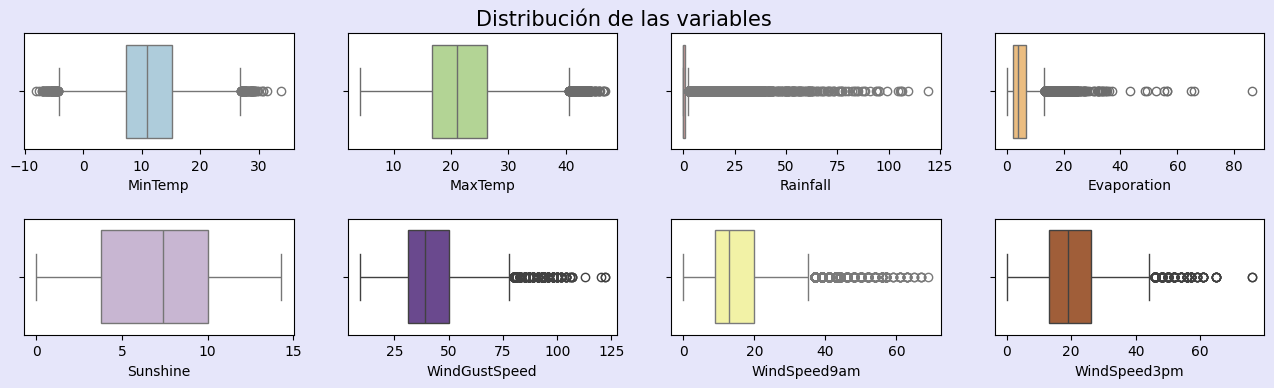

In [ ]:
# BOXPLOT DE LAS CARACTERÍSTICAS
box_plot(data,0,8)

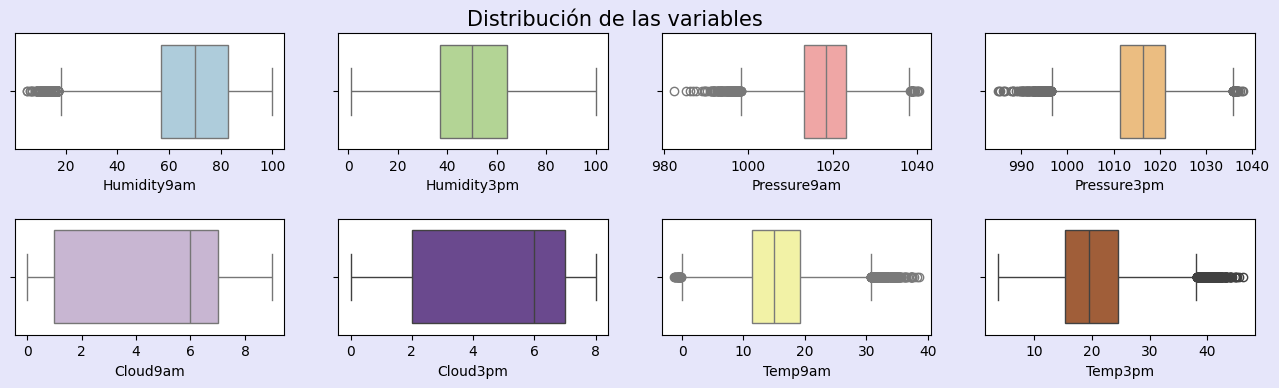

In [ ]:
box_plot(data,8,-1)

Como se puede ver, en la mayoría de las distribuciones se observan valores atípicos, pero esto puede deberse a que existen regiones climatológicas diferentes lo que genera mediciones por debajo del mínimo o por encima del máximo registrado en la medición general.

`No sería conveniente eliminar los valores atípicos porque se perderían tendencias reales.`

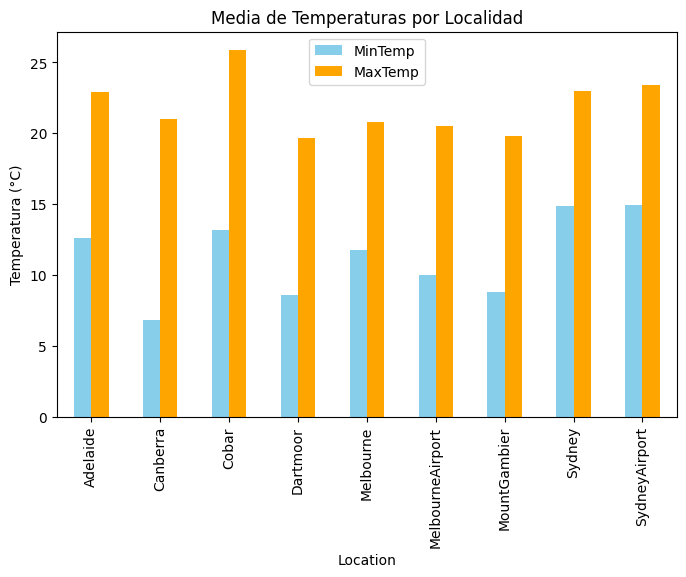

In [ ]:
# DATOS POR LOCALIDAD AGRUPADOS Y CALCULO DE LA MEDIA DE CADA TEMPERATURA
measures_by_location = data.groupby('Location').agg({'MinTemp': 'mean', 'MaxTemp': 'mean'})

measures_by_loc = pd.DataFrame({'MinTemp': measures_by_location['MinTemp'], 'MaxTemp': measures_by_location['MaxTemp']})
measures_by_loc.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'orange'])

plt.ylabel('Temperatura (°C)')
plt.title('Media de Temperaturas por Localidad')
plt.legend(loc='upper center')
plt.show()

**Observación:**

*   Las temperatura media máxima en las diferentes localidades se encuentra entr 20°C y 25°C.
*   Las temperatura media mínima en las diferentes localidades se encuentra entr 6°C y 15°C.

### **Codificación de características**

In [ ]:
# CODIFICACIÓN DE LA COLUMNA 'Date' QUE ALMACENA LAS FECHAS
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

# MAPEA EN 0 Y 1, Y CONSERVA LOS nan
data.RainTomorrow = data.RainTomorrow.map({'Yes':1, 'No':0})

# CODIFICACIÓN One-Hot
cod_data = pd.get_dummies(data, drop_first=True)

-   Para codificar la fecha, primero se convierte la columna en datetime y se descompone en día, mes y año respectivamente. Estas nuevas columnas son de tipo int32.

-   La columna RainTomorrow que va a ser utiizada para un modelo de clasificación más adelante es mapeada en 1 y 0.

-   En el caso de las demás variables categóricas, se utiliza una codificación One-Hot, ya que mejora muy ligeramente algunas métricas con respecto a otros codificadores que fueron probados, que reducen el número de columnas generadas a costo de perder algo de información.

## **Train test split**

**La división del set de datos en train y test toma en cuenta patrones estacionales, por lo que se decide no dividir aleatoriamente y tratar de conservarlos lo más que se pueda. Por lo tanto:**

*   Se establece como límite el 31-12-2015 para acumular aproximadamente el 80% de los datos en train, de los cuáles un 12% de estos se utilizan para validación.

*   El 20% restante de los datos (desde el 01-11-2015 en adelante) se utilizan para testeo.

In [ ]:
# CALCULOS PARA ESTABLECER LIMITES DE SEPARACIÓN DEL SET DE DATOS
train_shape = (len(data[data.Date <= '2015-12-31'])/len(data))*100
validation_shape = (len(data[data.Date.between('2015-01-01', '2015-12-31')])/len(data.Date))*100
print(f'Tamaño de train: {round(train_shape,)}%\nDe los cuales {round(validation_shape,)}% son para validación')

Tamaño de train: 83%
De los cuales 12% son para validación


In [ ]:
# FUNCIÓN PAR REALIZAR EL SPLIT DEL CONJUNTO DE DATOS
def split_data_validation(data, target_variable, exclude_variable=None):
  """
  Función para dividir el conjunto de datos de este trabajo, en conjuntos de entrenamiento, prueba y validación basada en fechas.
  Parámetros:
  - data: DataFrame original.
  - target_variable: Variable a predecir.
  - exclude_variable: Variable a excluir además de la dependiente.
  """
  x_train = data[data.Date <= '2014-12-31'].drop([target_variable, exclude_variable, 'Date'], axis=1).copy()
  x_test = data[data.Date >= '2016-01-01'].drop([target_variable, exclude_variable, 'Date'], axis=1).copy()
  y_train = data[data.Date <= '2014-12-31'][target_variable].values.reshape(-1, 1)
  y_test = data[data.Date >= '2016-01-01'][target_variable].values.reshape(-1, 1)

  x_val = data[data.Date.between('2015-01-01', '2015-12-31')].drop([target_variable, exclude_variable, 'Date'], axis=1).copy()
  y_val = data[data.Date.between('2015-01-01', '2015-12-31')][target_variable].values.reshape(-1, 1)

  # Tamaño de los conjuntos
  print(f'Total de datos en el conjunto de entrenamiento: {x_train.shape[0]} ({round(x_train.shape[0] / data.shape[0], 2)}%)\n'
        f'Total de datos en el conjunto de prueba: {x_test.shape[0]} ({round(x_test.shape[0] / data.shape[0], 2)}%)\n'
        f'Total de datos en el conjunto de validación: {x_val.shape[0]} ({round(x_val.shape[0] / data.shape[0], 2)}%)')

  return x_train, x_test, x_val, y_train, y_test, y_val

### **Imputación de datos faltantes**

In [ ]:
# FUNCIÓN PARA IMPUTAR DATOS CATEGÓRICOS
def fill_categorical_nan(train_data, val_data, test_data):
  """
  Función para llenar valores NaN en variables categóricas.
  Parámetros:
  - train_data: DataFrame que contiene los datos de entrenamiento.
  - val_data: DataFrame que contiene los datos de validación.
  - test_data: DataFrame que contiene los datos de prueba.
  """
  variables_categoricas = train_data.select_dtypes(include=['bool']).columns.tolist()

  for var in variables_categoricas:
    train_data[var].fillna(train_data[var].mode()[0], inplace=True)
    val_data[var].fillna(train_data[var].mode()[0], inplace=True)
    test_data[var].fillna(train_data[var].mode()[0], inplace=True)
  return train_data, val_data, test_data

In [ ]:
# FUNCIÓN PARA IMPUTAR  DATOS NUMÉRICOS
def fill_numerical_nan(train_data, val_data, test_data, y_train, y_test, y_val):
    """
    Función para llenar valores NaN en variables numéricas y reemplazar valores NaN en variables objetivo con la mediana.
    Parámetros:
    - train_data: DataFrame que contiene los datos de entrenamiento.
    - val_data: DataFrame que contiene los datos de validación.
    - test_data: DataFrame que contiene los datos de prueba.
    - y_train: Variable objetivo para los datos de entrenamiento.
    - y_test: Variable objetivo para los datos de prueba.
    - y_val: Variable objetivo para los datos de validación.
    """
    # Datos numéricos
    variables_numericas = train_data.select_dtypes(exclude=['object', 'bool']).columns.tolist()

    for column in variables_numericas:
        train_data[column].fillna(train_data[column].median(), inplace=True)
        test_data[column].fillna(train_data[column].median(), inplace=True)
        val_data[column].fillna(train_data[column].median(), inplace=True)

    # Mediana de y_train
    mediana = np.nanmedian(y_train)

    # Remplazar los valores nuloes en y_train, y_test y y_val con la mediana
    y_train = np.nan_to_num(y_train, nan=mediana)
    y_test = np.nan_to_num(y_test, nan=mediana)
    y_val = np.nan_to_num(y_val, nan=mediana)

    return train_data, val_data, test_data, y_train, y_test, y_val

**Notas:**

*   Para tratar los datos faltantes en las variables categóricas, se los imputara con la moda. En el caso de las variables numéricas, se lo hará con la mediana, ya que suele ser una medida más robusta antes los valores atípicos.

*   Las medidas estadísticas que se utilizaron para completar los valores faltantes tanto en train, test y validación, se extraen únicamente del conjunto de train. Esto es para evitar un sobreajuste.

### **Estandarización**

In [ ]:
# FUNCIÓN PARA ESTANDARIZAR DATOS
def standard_scaler(train_data, test_data, val_data):
  """
  Función para escalar datos usando StandardScaler.
  Parámetros:
  - train_data: DataFrame que contiene los datos de entrenamiento.
  - test_data: DataFrame que contiene los datos de prueba.
  - val_data: DataFrame que contiene los datos de validación.
  """
  scaler = StandardScaler()
  train_data = scaler.fit_transform(train_data)
  test_data = scaler.transform(test_data)
  val_data = scaler.transform(val_data)
  return train_data, test_data, val_data

Se escalan los datos utilizando la estandarización, ya que se presentan datos con escalas muy diferentes. De esta manera todas la características contribuiran de manera similar, y se mejora la robustez frente a valores atípicos.

---

### **Split para el modelo de regresión**

In [ ]:
x_train, x_test, x_val, y_train, y_test, y_val = split_data_validation(cod_data,
                                                                       'RainfallTomorrow',
                                                                       'RainTomorrow')

Total de datos en el conjunto de entrenamiento: 20079 (0.71%)
Total de datos en el conjunto de prueba: 4869 (0.17%)
Total de datos en el conjunto de validación: 3285 (0.12%)


###**Análisis multivariable**

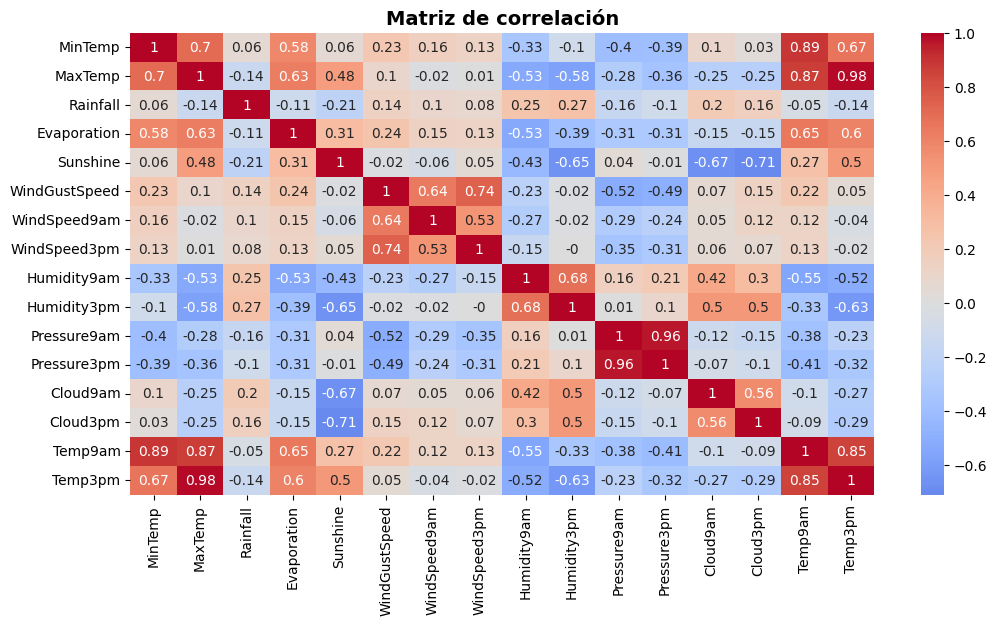

In [ ]:
# MATRIZ DE CORRELACIÓN
warnings.filterwarnings("ignore", category=FutureWarning)
corr = x_train.select_dtypes(exclude=['object','bool','int32']).corr().round(2)
plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title('Matriz de correlación',fontweight='bold',fontsize=14)
plt.show()

**Del mapa de calor de correlación anterior, se puede concluir que:**

*   Las variables MinTemp y MaxTemp están altamente correlacionadas positivamente (coeficiente de correlación = 0,7).

*  Las variables WindGustSpeed ​​y WindSpeed3pm están altamente correlacionadas positivamente (coeficiente de correlación = 0,74).

*   Las variables Temp9am y Temp3pm están fuertemente correlacionadas positivamente (coeficiente de correlación = 0,85).

*   Las variables MaxTemp y Temp9am están fuertemente correlacionadas positivamente (coeficiente de correlación = 0,87).

*   Las variables MinTemp y Temp9am están fuertemente correlacionadas positivamente (coeficiente de correlación = 0,89).

*   Las variables MaxTemp y Temp3pm también están fuertemente correlacionadas positivamente (coeficiente de correlación = 0,98).

*   Las variables Presión9am y Presión3pm están fuertemente correlacionadas positivamente (coeficiente de correlación = 0,96).


## **Modelos**

### **Regresión lineal**

`Se intentara predecir la variable RainfallTomorrow, que representa los cm3 de lluvia caídos al día siguiente de una observación.`

**Imputación de datos faltantes**

In [ ]:
# RELLENAR DATOS CATEGÓRICOS
x_train, x_val, x_test = fill_categorical_nan(x_train, x_val, x_test )

# RELLENAR DATOS NUMÉRICOS
x_train, x_val, x_test, y_train, y_test, y_val = fill_numerical_nan(x_train, x_val, x_test, y_train, y_test, y_val)

**Estandarización**

In [ ]:
# ESTANDARDIZAR LOS DATOS
x_train_scaled, x_test_scaled, x_val_scaled = standard_scaler(x_train, x_test, x_val)

La imputación de datos faltantes y la posterior estandarización, se realizan con las funciones definidas previamente.

In [ ]:
# INSTANCIAR MODELO
lr_model = LinearRegression(fit_intercept=True)

# ENTRENAR MODELO
lr_model.fit(x_train_scaled,y_train)

LinearRegression()

In [ ]:
# PENDIENTE E INTERCEPTO
lr_model.coef_, lr_model.intercept_

(array([[-0.44585465,  0.49470185,  0.71651326,  0.08503816, -0.79683103,
          1.28230986,  0.0481181 , -0.50587538, -0.17602486,  2.3379032 ,
          2.39889036, -2.92662781, -0.1348145 ,  0.20004733,  0.0304447 ,
          0.31584991,  0.03916694, -0.01360545, -0.00688447, -0.03840006,
          0.07157368, -0.44123458, -0.25783655, -0.33682434, -0.2453022 ,
          0.06403902,  0.03001071, -0.08206783,  0.01555906, -0.15610396,
         -0.10910686, -0.1084535 , -0.08895821, -0.10421552, -0.10619112,
          0.08555188,  0.00976143, -0.06758515, -0.12424787, -0.16867777,
         -0.09944409, -0.07965019,  0.01482404,  0.02727717, -0.20727488,
          0.01459996,  0.00568081, -0.18886432, -0.1865641 , -0.14840838,
          0.02027657, -0.04154819, -0.10236166, -0.12163791, -0.15388792,
         -0.1678734 , -0.03333227,  0.10312506,  0.18553678,  0.11701852,
          0.03311438,  0.16791242,  0.21390398,  0.16735774,  0.23600378,
          0.1636771 ,  0.179391  ,  0.

**Interpretación:**

**Los resultados impresos representan los coeficientes de la regresión lineal y la intersección, después de haber estandarizado los datos.**

-   La intersección, es el valor esperado de la variable dependiente cuando las variables explicativas son cero.

-   El valor del coeficiente se puede interpretar como un incremento si el signo es positivo o un decremento en caso contrario, sobre la varible dependiente, cuando esta aumenta en un unidad.



In [ ]:
# FUNCIÓN PARA OBTENER LAS MÉTRICAS DE LOS MODELOS
def metrics(train_data, test_data, y_train, y_test, y_pred, modelo):
  """
  Función para visualizar métricas como R2, MSE, RMSE y MAE de los datos.
  Parámetros:
  - train_data: DataFrame que contiene los datos de entrenamiento.
  - test_data: DataFrame que contiene los datos de prueba.
  - val_data: DataFrame que contiene los datos de validación.
  - y_train: Variable objetivo para los datos de entrenamiento.
  - y_test: Variable objetivo para los datos de prueba.
  - y_pred: Predicciones hechas por el modelo.
  - modelo: Modelo utilizado para hacer las predicciones.
  """
  # Coeficiente de regresión
  r2_train, r2_test = round(modelo.score(train_data,y_train),3), round(modelo.score(test_data,y_test),3)
  # Error cuadrático medio
  mse = round(mean_squared_error(y_test, y_pred),3)
  # Raíz del error cuadrático medio
  rmse = round(mean_squared_error(y_test, y_pred, squared = False),3)
  # Error absoluto medio
  mae = round(mean_absolute_error(y_test, y_pred),3)

  return r2_train, r2_test, mse, rmse, mae

# FUNCIÓN PARA VISUALIZAR MÉTRICAS
def print_metrics(train_r2, test_r2, test_mse, test_rmse, test_mae):
  """
  Función para imprimir métricas.
  Parámetros:
  - Salidas de la función metricas().
  """
  print(f'\nEl R2 del test es: {test_r2}\n'),
  print(f'El R2 del train es: {train_r2}\n'),
  print(f'El MSE es: {test_mse}\n'),
  print(f'El RMSE es: {test_rmse}\n'),
  print(f'El error MAE es: {test_mae}\n')


**Para evaluar el desempeño de los modelos se van a seleccionar alguna métricas comunmente utilizadas y que permiten comprender como se ajustan los datos**.

-   R2: coeficiente que determina cuanta varibilidad en los datos es explicada por el modelo.
-   MSE: calcula el promedio de los errores cuadrados, cuanto menor sea mejor será la predicción.
-   RMSE: es la raíz cuadrada del MSE y es una medida más intuitiva, ya que se encuentra en la misma escala que la variable objetivo.
-   MAE: calcula el promedio de los errores absolutos y es más robusto frente a los valores atípicos. Cuanto menor sea mejor será la predicción.

In [ ]:
# PREDICCIONES REGRESIÓN LINEAL
y_pred_lr = lr_model.predict(x_test_scaled)

print_metrics(*metrics(x_train_scaled, x_test_scaled, y_train, y_test, y_pred_lr, lr_model))


El R2 del test es: 0.25

El R2 del train es: 0.222

El MSE es: 35.698

El RMSE es: 5.975

El error MAE es: 2.767



### **Gradiente descendiente**

In [ ]:
# FUNCIÓN PARA EL DESCENSO DE GRADIENTE
def gradient_descent(x_train,y_train,x_test,y_test,lr=0.01,epochs=100):

    n, m, o = x_train.shape[0], x_train.shape[1], x_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), x_train))
    X_test = np.hstack((np.ones((o, 1)), x_test))

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Almacenar el error de entrenamiento en cada época
    test_errors = []   # Aalmacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1
        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de test')
    plt.xlabel('Época'), plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    plt.show()

    return W

In [ ]:
# FUNCIÓN PARA EL DESCENSO DE GRADIENTE (MINI-BATCH)
def mini_batch_gd(data_train, y_data_train, data_test, y_data_test, lr=0.01, epochs=100, batch_size=11):

    n, m = data_train.shape[0], data_train.shape[1]

    # Poner columna de unos a las matrices X
    data_train = np.hstack((np.ones((n, 1)), data_train))
    data_test = np.hstack((np.ones((data_test.shape[0], 1)), data_test))

    # Inicializar pesos aleatorios
    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []  # Almacenar el error de entrenamiento en cada época
    test_errors = []   # Aalmacenar el error de prueba en cada época

    for i in range(epochs):

        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        data_train = data_train[permutation]
        y_data_train = y_data_train[permutation]

        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = data_train[j:j+batch_size, :]
            y_batch = y_data_train[j:j+batch_size].reshape(-1, 1)

            # Calcular predicción y error de entrenamiento
            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            # Calcular el gradiente y actualizar pesos
            gradient = -2 * np.matmul(x_batch.T, error) / batch_size
            W = W - (lr * gradient)

            # Calcular predicción y error de prueba
            prediction_test = np.matmul(data_test, W)
            error_test = y_data_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(5, 4))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

In [ ]:
# FUNCIÓN DE MÉTRICAS
def gd_metrics(test_predict, train_predict, y_test, y_train):
  """
  Función para visualizar métricas como R^2, MSE, RMSE y MAE de los datos.
  Parámetros:
  - train_predict: Predicciones para los datos de entrenamiento.
  - test_predict: Predicciones para los datos de prueba.
  - y_train: Variable objetivo para los datos de entrenamiento.
  - y_test: Variable objetivo para los datos de prueba.
  """
  # Calcular el coeficiente de determinación (R^2) para datos de test
  test_mean = np.mean(y_test)
  ss_total_test = np.sum((y_test - test_mean) ** 2)
  ss_residual_test = np.sum((y_test - test_predict) ** 2)
  test_r2 = round(1 - (ss_residual_test / ss_total_test), 3)

  # Calcular el coeficiente de determinación (R^2) para datos de train
  train_mean = np.mean(y_train)
  ss_total_train = np.sum((y_train - train_mean) ** 2)
  ss_residual_train = np.sum((y_train - train_predict) ** 2)
  train_r2 = round(1 - (ss_residual_train / ss_total_train), 3)

  # Calcular el error cuadrático medio (MSE) para test
  test_mse = round(np.mean((y_test - test_predict) ** 2), 3)

  # Calcular la raíz del error cuadrático medio (RMSE) para test
  test_rmse = round(np.sqrt(np.mean((y_test - test_predict) ** 2)), 3)

  # Calcular el error absoluto medio (MAE) para test
  test_mae = round(np.mean(np.abs(y_test - test_predict)), 3)

  return train_r2, test_r2, test_mse, test_rmse, test_mae

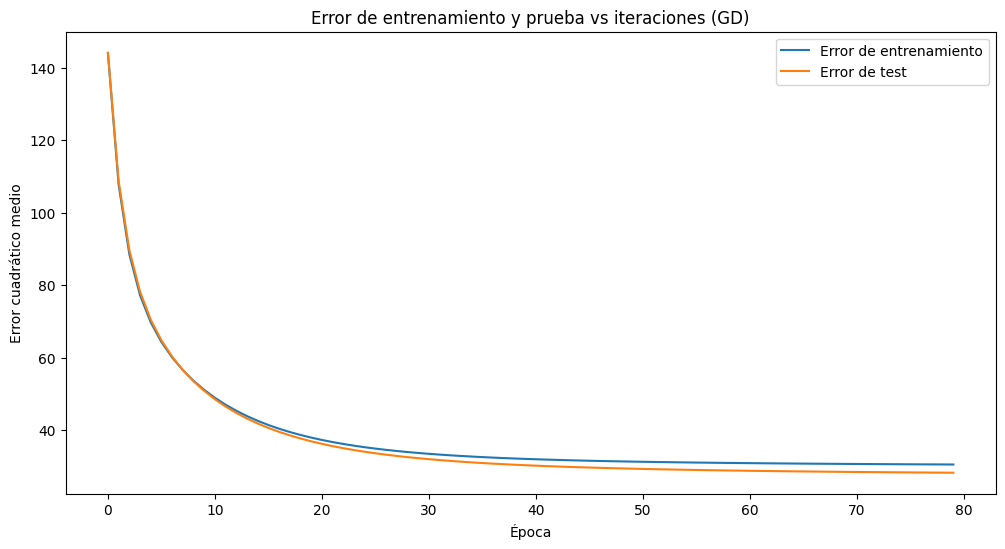

In [ ]:
# GRADIENTE DESCENDIENTE
gd = gradient_descent(x_train_scaled, y_train, x_val_scaled, y_val, lr=0.03, epochs=80)

Ambos errores disminuyen rápidamente y el modelo está convergiendo adecuadamente, ya que ambos errores se estabilizan después de varias épocas (20-30), indicando que el descenso de gradiente está funcionando correctamente.

La pequeña diferencia entre el error de entrenamiento y el error de prueba sugiere que el modelo tiene un buen rendimiento y generaliza bien en datos no vistos.

Dado que el error de prueba no aumenta y sigue una tendencia similar al error de entrenamiento, no parece haber sobreajuste.

In [ ]:
# PREDICCIONES GRADINTE DESCENDIENTE
x_test_gd = np.hstack((np.ones((x_test_scaled.shape[0], 1)), x_test_scaled))
x_train_gd = np.hstack((np.ones((x_train_scaled.shape[0], 1)), x_train_scaled))
test_predict_gd = np.matmul(x_test_gd, gd)
train_predict_gd = np.matmul(x_train_gd, gd)

# PREDICCIONES GD
print_metrics(*gd_metrics(test_predict_gd,train_predict_gd,y_test,y_train))


El R2 del test es: 0.219

El R2 del train es: 0.198

El MSE es: 37.217

El RMSE es: 6.101

El error MAE es: 2.882



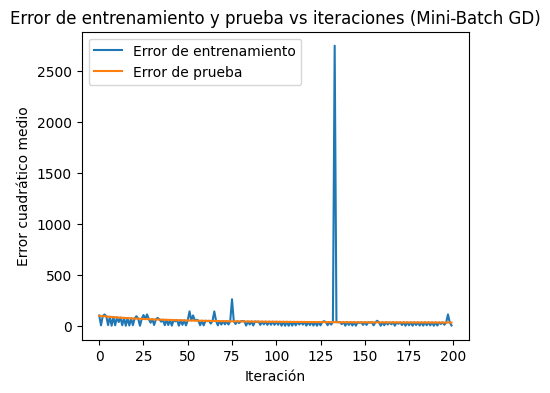

In [ ]:
# GRADIENTE DESCENDIENTE ESTOCÁSTICO
sgd = mini_batch_gd(x_train_scaled, y_train, x_val_scaled, y_val, lr=0.01, epochs=100, batch_size=(len(x_train_scaled) -1))

Tanto el error de entrenamiento como el error de prueba son bajos y bastante estables en la mayoría de las iteraciones.
Hay picos notables en el error de entrenamiento en ciertas iteraciones, lo que podría deberse a datos ruidosos en esos lotes específicos.

El error de prueba es mucho más estable y no muestra picos significativos. El rendimiento general del modelo en datos no vistos se mantiene consistente, y el modelo parece ser robusto en general.

In [ ]:
# PREDICCIONES GRADINTE DESCENDIENTE ESTOCÁSTICO
x_test_sgd = np.hstack((np.ones((x_test_scaled.shape[0], 1)), x_test_scaled))
x_train_sgd = np.hstack((np.ones((x_train_scaled.shape[0], 1)), x_train_scaled))
test_predict_sgd = np.matmul(x_test_sgd, sgd)
train_predict_sgd = np.matmul(x_train_sgd, sgd)

# PREDICCIONES GD
print_metrics(*gd_metrics(test_predict_sgd,train_predict_sgd,y_test,y_train))


El R2 del test es: 0.162

El R2 del train es: 0.136

El MSE es: 39.894

El RMSE es: 6.316

El error MAE es: 3.146



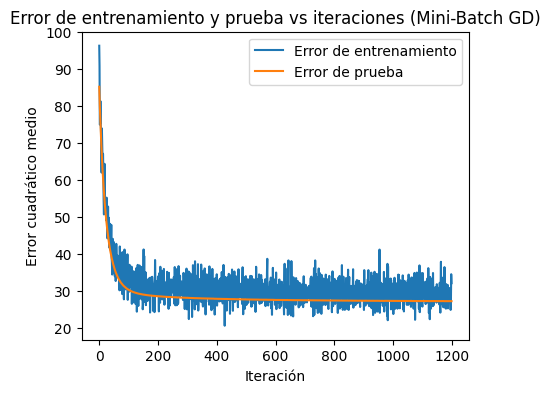

In [ ]:
# GRADIENTE DESCENDIENTE MINI BATCH
mbgd = mini_batch_gd(x_train_scaled, y_train, x_val_scaled, y_val, lr=0.01, epochs=300, batch_size=5096)

Ambos errores disminuyen bastante rápido, mientras el de prueba se mantiene estable, el de entrenamiento es más oscilante, lo que podría deberse a datos ruidosos en los lotes.







In [ ]:
# PREDICCIONES GRADINTE DESCENDIENTE MINI BATCH
x_test_mbgd = np.hstack((np.ones((x_test_scaled.shape[0], 1)), x_test_scaled))
x_train_mbgd = np.hstack((np.ones((x_train_scaled.shape[0], 1)), x_train_scaled))
test_predict_mbgd = np.matmul(x_test_mbgd, mbgd)
train_predict_mbgd = np.matmul(x_train_mbgd, mbgd)

# PREDICCIONES GD
print_metrics(*gd_metrics(test_predict_mbgd,train_predict_mbgd,y_test,y_train))


El R2 del test es: 0.242

El R2 del train es: 0.218

El MSE es: 36.106

El RMSE es: 6.009

El error MAE es: 2.779



### **Regularización**

**Ridge**

In [ ]:
# INSTANCIAR MODELO
r_model = RidgeCV(alphas = np.logspace(-10, 10, 200),
                 fit_intercept   = True,
                 store_cv_values = True)

# ENTRENAR MODELO
r_model.fit(x_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-10, 1.26038293e-10, 1.58856513e-10, 2.00220037e-10,
       2.52353917e-10, 3.18062569e-10, 4.00880633e-10, 5.05263107e-10,
       6.36824994e-10, 8.02643352e-10, 1.01163798e-09, 1.27505124e-09,
       1.60705282e-09, 2.02550194e-09, 2.55290807e-09, 3.21764175e-09,
       4.05546074e-09, 5.11143348e-09, 6.44236351e-09, 8.11984499e-09,
       1.02341140e-08, 1.28989026e-0...
       4.88025158e+07, 6.15098579e+07, 7.75259749e+07, 9.77124154e+07,
       1.23155060e+08, 1.55222536e+08, 1.95639834e+08, 2.46581108e+08,
       3.10786619e+08, 3.91710149e+08, 4.93704785e+08, 6.22257084e+08,
       7.84282206e+08, 9.88495905e+08, 1.24588336e+09, 1.57029012e+09,
       1.97916687e+09, 2.49450814e+09, 3.14403547e+09, 3.96268864e+09,
       4.99450512e+09, 6.29498899e+09, 7.93409667e+09, 1.00000000e+10]),
        store_cv_values=True)

In [ ]:
# PREDICCIONES RIDGE
y_pred_r = r_model.predict(x_test_scaled)

print_metrics(*metrics(x_train_scaled, x_test_scaled, y_train, y_test, y_pred_r, r_model))


El R2 del test es: 0.25

El R2 del train es: 0.222

El MSE es: 35.714

El RMSE es: 5.976

El error MAE es: 2.765



**Lasso**

In [ ]:
# INSTANCIAR MODELO
l_model = LassoCV(alphas=np.logspace(-10, 10, 200),cv=10)

# ENTRENAR MODELO
_ = l_model.fit(x_train_scaled, y_train.ravel())

In [ ]:
# PREDICCIONES LASSO
y_pred_l = l_model.predict(x_test_scaled)

print_metrics(*metrics(x_train_scaled, x_test_scaled, y_train, y_test, y_pred_l, l_model))


El R2 del test es: 0.248

El R2 del train es: 0.221

El MSE es: 35.795

El RMSE es: 5.983

El error MAE es: 2.742



**ElasticNet**

In [ ]:
# INSTANCIAR MODELO
e_model = ElasticNetCV(l1_ratio = [0.01, 0.05, 0.35, 0.4, 0.9],
                      alphas = np.logspace(-5, 10, 200),
                      cv = 5)

# ENTRENAR MODELO
_ = e_model.fit(x_train_scaled, y_train.ravel())

In [ ]:
# PREDICCIONES ELASTIC NET
y_pred_e = e_model.predict(x_test_scaled)

print_metrics(*metrics(x_train_scaled, x_test_scaled, y_train, y_test, y_pred_e, e_model))


El R2 del test es: 0.248

El R2 del train es: 0.221

El MSE es: 35.819

El RMSE es: 5.985

El error MAE es: 2.74



### **Métricas**


**Comparación entre modelos**

In [ ]:
# NOMBRE DE LOS MODELOS
models = ['LR','RIDGE', 'LASSO', 'E.NET', 'GD', 'GD-STC','GD-MB']

# MÉTRICAS CALCULADAS
metrics = ['R2_TRAIN', 'R2_TEST', 'MSE', 'RMSE', 'MAE']

# DATAFRAME PARA COMPARAR MÉTRICAS
metrics_df = pd.DataFrame(index=metrics, columns=models)

# METRICAS GD
test_r2_1, train_r2_1, test_mse_1, test_rmse_1, test_mae_1 = gd_metrics(test_predict_gd,train_predict_gd,y_test,y_train)
test_r2_2, train_r2_2, test_mse_2, test_rmse_2, test_mae_2 = gd_metrics(test_predict_sgd,train_predict_sgd,y_test,y_train)
test_r2_3, train_r2_3, test_mse_3, test_rmse_3, test_mae_3 = gd_metrics(test_predict_mbgd,train_predict_mbgd,y_test,y_train)

values = [
    [lr_model.score(x_train_scaled,y_train).round(3),
     r_model.score(x_train_scaled,y_train).round(3),
     l_model.score(x_train_scaled,y_train).round(3),
     e_model.score(x_train_scaled,y_train).round(3),
     train_r2_1,train_r2_2,train_r2_3],
    [lr_model.score(x_test_scaled,y_test).round(3),
     r_model.score(x_test_scaled,y_test).round(3),
     l_model.score(x_test_scaled,y_test).round(3),
     e_model.score(x_test_scaled,y_test).round(3),
     test_r2_1,test_r2_2,test_r2_3],
    [mean_squared_error(y_test, y_pred_lr).round(3),
     mean_squared_error(y_test, y_pred_r).round(3),
     mean_squared_error(y_test, y_pred_l).round(3),
     mean_squared_error(y_test, y_pred_e).round(3),
     test_mse_1,test_mse_2,test_mse_3],
    [mean_squared_error(y_test, y_pred_lr, squared = False).round(3),
     mean_squared_error(y_test, y_pred_r, squared = False).round(3),
     mean_squared_error(y_test, y_pred_l, squared = False).round(3),
     mean_squared_error(y_test, y_pred_e, squared = False).round(3),
     test_rmse_1,test_rmse_2,test_rmse_3],
    [mean_absolute_error(y_test, y_pred_lr).round(3),
     mean_absolute_error(y_test, y_pred_r).round(3),
     mean_absolute_error(y_test, y_pred_lr).round(3),
     mean_absolute_error(y_test, y_pred_e).round(3),
     test_mae_1,test_mae_2,test_mae_3]
]

# RELLENAR DF
for i, metric in enumerate(metrics):
    metrics_df.loc[metric] = values[i]

In [ ]:
# COMPARACIÓN DE LAS MÉTRICAS EN LOS DIFERENTES MODELOS
metrics_df

,LR,RIDGE,LASSO,E.NET,GD,GD-STC,GD-MB
R2_TRAIN,0.222,0.222,0.221,0.221,0.219,0.162,0.242
R2_TEST,0.25,0.25,0.248,0.248,0.198,0.136,0.218
MSE,35.698,35.714,35.795,35.819,37.217,39.894,36.106
RMSE,5.975,5.976,5.983,5.985,6.101,6.316,6.009
MAE,2.767,2.765,2.767,2.74,2.882,3.146,2.779


Como se puede observar en el cuadro de arriba, la variación de las métricas calculadas es infima, por lo que los modelos están proporcionando resultados bastante similares en términos de ajuste y precisión en la predicción.

Si habría que elegir alguno de los modelos, sería conveniente no considerar gradiente descendiente el cual obtuvo las peores métricas.  Entre la regresión lineal con y sin regularizción, quizas la regresón lineal sin regularizar sería la elegida por la implementación de un código más simple, ya que en terminos de eficiencia es similar a las demás.

**Intepretación**

Los resultados obtenidos muestran que los modelos de regresión lineal, incluyendo gradiente descendiente, Ridge, Lasso y Elastic Net, no logran capturar de manera efectiva la variabilidad presente en el conjunto de datos, como lo indica el bajo coeficiente de determinación (R2). Con un R2 aproximadamente del 25% en la mayoría de los modelos, se estima que solo alrededor del 25% de la variabilidad en la variable objetivo es explicada, lo que sugiere que la regresión lineal podría no ser la mejor opción para este problema en particular.

---
### **Clasificación**

`Se intentara predecir la variable RainTomorrow, que indica si llovió o no al día siguiente a una observación.`

**Split**



In [ ]:
x_train_log, x_test_log, x_val_log, y_train_log, y_test_log, y_val_log = split_data_validation(cod_data,
                                                                                              'RainTomorrow',
                                                                                              'RainfallTomorrow')

Total de datos en el conjunto de entrenamiento: 20079 (0.71%)
Total de datos en el conjunto de prueba: 4869 (0.17%)
Total de datos en el conjunto de validación: 3285 (0.12%)


**Imputación de datos faltantes**

In [ ]:
# RELLENAR DATOS CATEGÓRICOS
x_train_log, x_val_log, x_test_log = fill_categorical_nan(x_train_log, x_val_log, x_test_log)

# RELLENAR DATOS NUMÉRICOS
x_train_log, x_val_log, x_test_log, y_train_log, y_test_log, y_val_log = fill_numerical_nan(x_train_log, x_val_log, x_test_log, y_train_log, y_test_log, y_val_log)

**Estandarización**

In [ ]:
# ESTANDARDIZAR LOS DATOS
x_train_log_scaled, x_test_log_scaled, x_val_log_scaled = standard_scaler(x_train_log, x_test_log, x_val_log)

Tanto para generar la división del conjunto de datos, como la imputación de datos faltantes y la posterior estandarización, se realizan con las funciones definidas previamente.

**Regresión logística**

In [ ]:
# INSTANCIAR MODELO
logistic_model = LogisticRegression(random_state=12, class_weight='balanced')

# ENTRENAR MODELO
logistic_model.fit(x_train_log_scaled, y_train_log.ravel())

LogisticRegression(class_weight='balanced', random_state=12)


Para solucionar el problema del desbalance de clases en la variable objetivo, se utiliza el parámetro class_weight que permite indicarle al modelo como manejarlo.

En este caso se utiliza el peso de las clase como balanceado, el cual le dice al modelo que debe asignarle un peso mayor a la clase minoritaria y un peso menor a la mayoritaria. De esta manera el algoritmo presta más atención a la clase desbalanceada, pudiendo así mejorar el rendimiento y predicción.



In [ ]:
# PREDICCIONES OBTENIDAS DE LA REGRESIÓN LOGÍSTICA
y_pred_log_test = logistic_model.predict(x_test_log_scaled)
y_pred_log_train = logistic_model.predict(x_train_log_scaled)

# PROBABILIDADES DE PREDICCIÓN DEL MODELO
y_probs_train = logistic_model.predict_proba(x_train_log_scaled)[:, 1]
y_probs_test = logistic_model.predict_proba(x_test_log_scaled)[:, 1]

---
**Métricas**


**Al igual que en la regresión, se van a uilizar una serie de métricas que permiten observar el desempeño del modelo. En este caso, no observamos el error en las distancias de las predicciones, sino la capacidad del modelo de poder predecir correctamente una clase**.

**Métricas observadas:**
-   **Accuracy (exactitud):** representa la cantidad de aciertos en comparación del total de datos. Esta métrica es efectiva en el caso de que los datos estén balancedos.
-   **Recall (sensibilidad-TPR):** mide la proporción de positivos reales que son correctamente identificados por el modelo.
-   **Specificity (TNR):** es la métrica complementaria del recall, representa cuantos de los ejemplos negativos fueron clasificados correctamente como negativos.
-   **Precisión:** La precisión es la proporción de verdaderos positivos entre el total de predicciones positivas realizadas (tanto verdaderos positivos como falsos positivos). Menor cantidad de falsos positivos, mayor precisión.

-   **F1-Score:** esta métrica toma en cuenta a la precisión y el recall, ya que es una media armónica de estas. Puede ser útil en el caso de que las clases esten desbalanceadas.

In [ ]:
# REPORTES PARA EL CONJUNTO DE TRAIN
report_trn = classification_report(y_train_log, y_pred_log_train, output_dict=True)
report_trn.pop('accuracy')
df_trn = round(pd.DataFrame(report_trn).transpose(),2); df_trn

,precision,recall,f1-score,support
0.0,0.92,0.80,0.86,15411.0
1.0,0.54,0.78,0.64,4668.0
macro avg,0.73,0.79,0.75,20079.0
weighted avg,0.83,0.80,0.81,20079.0


In [ ]:
# REPORTES PARA EL CONJUNTO DE TEST
report_tst = classification_report(y_test_log, y_pred_log_test, output_dict=True)
report_tst.pop('accuracy')
df_tst = round(pd.DataFrame(report_tst).transpose(),2); df_tst

,precision,recall,f1-score,support
0.0,0.92,0.81,0.86,3708.0
1.0,0.56,0.76,0.64,1161.0
macro avg,0.74,0.79,0.75,4869.0
weighted avg,0.83,0.80,0.81,4869.0


In [ ]:
# EXACTITUD (ACCURACY)
accuracy = accuracy_score(y_test_log, y_pred_log_test)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.80



**Los resultados obtenidos en los reportes de los conjuntos de datos de train y test son similares, lo que se puede interpretar como que hubo un buen fit.**

**Por un lado de la clase 0 vemos:**
- La **precisión** es bastante alta (la tasa de falsos positivos es muy baja).
-  EL **recall** indica que el 81% aproximadamente de las instancias fueron predichas correctamente.
-  El **F1** también es muy alto, lo que indica un balance entre el accuracy y la precisión.

**Por otro lado de la clase 1 vemos:**
- La **precisión** es bastante baja, lo que significa que la tasa de falsos positivos es muy alta.
-  EL **recall** indica que el 76% aproximadamente de las instancias fueron predichas correctamente.
-  El **F1** es relativamente bajo, lo que indica que no hay un buen balance entre el accuracy y la precisión.

El accuracy no debería ser tenido en cuenta ya que las clases se encuentran desbalanceadas y no es una medida útil o confiable en este caso.

---

**Visualización matriz de confusión**

**Una matriz de confusión nos permite observar el desempeño de un modelo de clasificación y nos dará una imagen clara del rendimiento y los tipos de errores producidos por el modelo.**

**Resultados posibles al evaluar el desempeño del modelo de clasificación:**

-   **Verdaderos positivos (TP):** ocurren cuando predecimos que una observación pertenece a una determinada clase y la observación en realidad pertenece a esa clase.

-   **Verdaderos Negativos (TN):** ocurren cuando predecimos que una observación no pertenece a una determinada clase y la observación en realidad no pertenece a esa clase.

-   **Falsos positivos (FP):** ocurren cuando predecimos que una observación pertenece a una determinada clase, pero la observación en realidad no pertenece a esa clase.

-   **Falsos negativos (FN):** ocurren cuando predecimos que una observación no pertenece a una determinada clase, pero la observación en realidad pertenece a esa clase.

In [ ]:
# CALCULAR MATRIZ DE CONFUSIÓN
cm_test = confusion_matrix(y_test_log, y_pred_log_test)
cm_train = confusion_matrix(y_train_log, y_pred_log_train)

In [ ]:
# FUNCIÓN PARA PLOTEAR MATRICES DE CONFUSIÓN
def evaluate_model(y_test_true, y_test_pred, y_train_true, y_train_pred,titles=['Prueba', 'Entrenamiento'], figsize=(10, 4)):
    """
    Evalúa el rendimiento del modelo calculando el recall y generando matrices
    de confusión para los conjuntos de entrenamiento y prueba.

    Parámetros:
    y_train_true: Etiquetas verdaderas del conjunto de entrenamiento.
    y_train_pred: Etiquetas predichas del conjunto de entrenamiento.
    y_test_true: Etiquetas verdaderas del conjunto de prueba.
    y_test_pred: Etiquetas predichas del conjunto de prueba.
    """

    # Calcular las matrices de confusión
    cm_train = confusion_matrix(y_train_true, y_train_pred)
    cm_test = confusion_matrix(y_test_true, y_test_pred)

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    for ax, cm, title in zip(axes, [cm_test, cm_train], titles):
        cm_df = pd.DataFrame(cm, columns=['Negativo:0', 'Positivo:1'], index=['Negativo:0', 'Positivo:1'])
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu', ax=ax)
        ax.set_title(f'Matriz de Confusión ({title})')

    plt.tight_layout()
    plt.show()

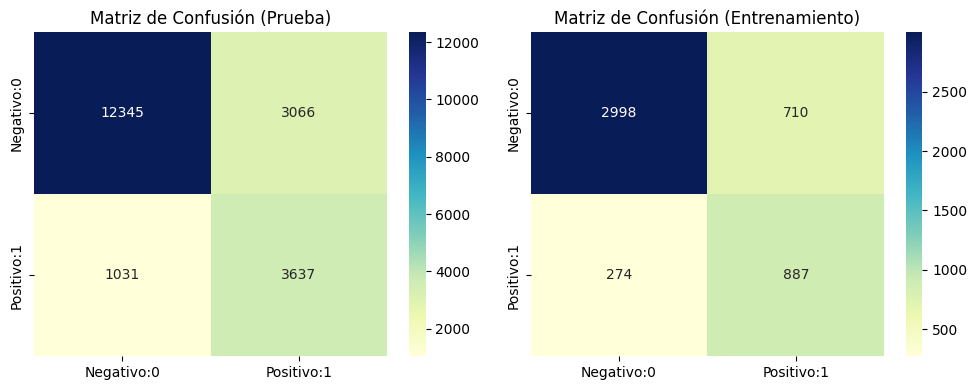

In [ ]:
evaluate_model(y_train_log, y_pred_log_train, y_test_log, y_pred_log_test)

**Para el conjunto de prueba nos encontramos con:**
- 710 casos de "Falsos Negativos" siendo casos perdidos o no detectados, donde el modelo predijo incorrectamente que las instancias pertenecen a la clase negativa (0) cuando en realidad pertenecen a la clase positiva (1). Es perder la detección de casos positivos reales.
- 274 casos de "Falsos Positivos" siendo casos identificados erróneamente como positivos, donde el modelo predijo incorrectamente que las instancias pertenecen a la clase positiva (1) cuando en realidad pertenecen a la clase negativa (0).

**Y para el conjunto de entrenamiento tenemos:**
- 3066 casos de "Falsos Negativos".
- 1031 casos de "Falsos Positivos".

---

**Curva ROC**

Gráfica que muestra la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para diferentes umbrales de decisión. Un umbral 0 indica que se predice solo la clase positiva, un umbral 1 la clase negativa.

In [ ]:
# CALCULO DE LA ROC Y EL AUC
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_log, y_probs_test)
roc_auc_test = auc(fpr_test, tpr_test)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train_log, y_probs_train)
roc_auc_train = auc(fpr_train, tpr_train)

# FUNCIÓN PARA PLOTEAR LA CURVA ROC
def plot_roc_curve(fpr, tpr, roc_auc, title):
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(title)
    plt.legend(loc="lower right")

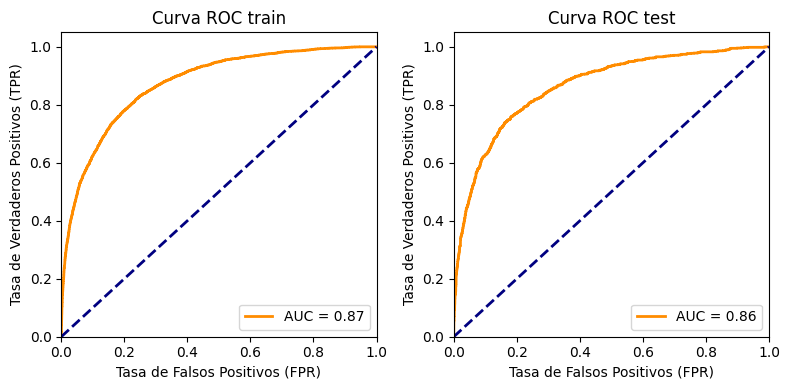

In [ ]:
plt.figure(figsize=(8, 4))
# Curva ROC para el conjunto de entrenamiento
plt.subplot(121)
plot_roc_curve(fpr_train, tpr_train, roc_auc_train, 'Curva ROC train')

# Curva ROC para el conjunto de prueba
plt.subplot(122)
plot_roc_curve(fpr_test, tpr_test, roc_auc_test, 'Curva ROC test')

plt.tight_layout()
plt.show()

El área bajo la curva ROC (AUC) mide la capacidad del modelo para distinguir entre clases positivas y negativas. No depende de un umbral específico. Cuanto mayor sea el valor mejor será el desempeño.

El AUC ROC para ambos conjuntos en este caso se encuentra más cerca de 1 que de 0, por lo que podríamos decir que el modelo hace un buen trabajo en diferenciar las clases.

---




**Ajustes de umbral (threshold)**

En clasificación binaria se utiliza un umbral de decisión para convertir las probabilidades en etiquetas de clases. Por defecto, los modelos utilizan un umbral de 0.5, es decír, que las instancias con probabilidades mayor a 0.5 se clasifican como positivas.

Este umbral se puede ajustar para aumentar la sensibilidad o la especificidad. La sensibilidad y la especificidad tienen una relación inversa, aumentar una siempre disminuiría la otra y viceversa.

Para nuestro objetivo podemos ajustar el umbral para optimizar alguna métrica de interes. Teniendo en cuenta que las clases están desbalanceadas sería mejor quizas la puntuación F1 para intentar obtener un resultado balaceado entre el recall y la precisión.

In [ ]:
# OPTIMIZAR EL F1
best_ths = [] #Mejores umbrales hallados
best_f1 = [] #Mejor F1 hallado
# Calcular F1 para un rango de umbrales
for threshold in np.arange(0.5,0.9,0.01):
  y_pred_custom = (y_probs_test >= threshold).astype(int)
  f1 = round(f1_score(y_test_log, y_pred_custom),2)
  if f1 > 0.64:
    best_f1.append(f1)
    best_ths.append(threshold)

# Mejor umbral hallado para el mayor puntaje F1
idx = best_f1.index(max(best_f1))
best_th = best_ths[idx]
print(f'Mejor umbral: {best_th}\nPuntuación F1: {best_f1[idx]}')

Mejor umbral: 0.56
Puntuación F1: 0.66


In [ ]:
# PROBABILIDADES CON EL MEJOR UMBRAL HALLADO
y_best_pred = (y_probs_test >= best_th)

# REPORTE DE CLASIFICACIÓN
report = classification_report(y_test_log, y_best_pred, output_dict=True)
report.pop('accuracy')
report = round(pd.DataFrame(report).transpose(),2); report

,precision,recall,f1-score,support
0.0,0.91,0.85,0.88,3708.0
1.0,0.60,0.72,0.66,1161.0
macro avg,0.75,0.79,0.77,4869.0
weighted avg,0.83,0.82,0.82,4869.0


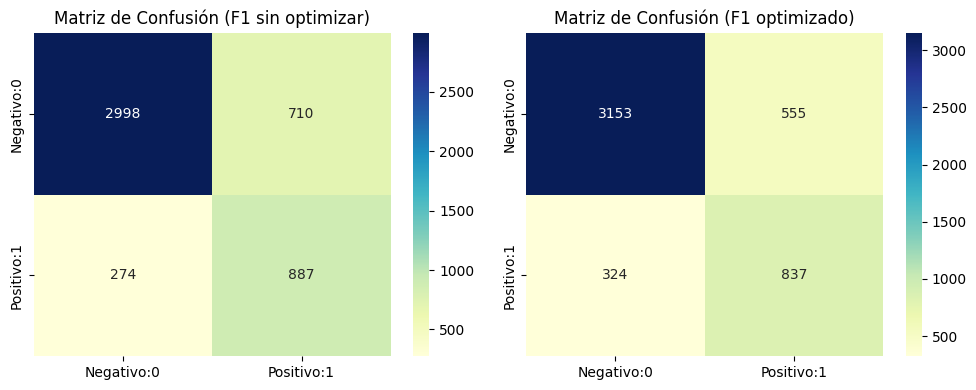

In [ ]:
# PLOTEAR MATRICES DE CONFUSIÓN
evaluate_model(y_test_log, y_pred_log_test, y_test_log, y_best_pred, ['F1 sin optimizar','F1 optimizado'])

**Conclusión del ajuste del umbral:**

-  Leve mejoría en el F1 de ambas clases.
-  Mejoría en el caso de los TPR de la clase 0, aunque una pequeña disminucion de los TPR en la clase 1.
-  En cuanto a la precisión, se mantuvo para la clase 0 y mejoró levemente en la clase 1.

Como el objetivo de este modelo es predecir si llovió o no al día siguiente, quizas no sea muy correcto inclinarse a mejorar alguna clase sobre la otra en terminos generales. Pero considerando que este es un umbral óptimo para el F1 y moverse hacia otro empeoraría las predicciones para alguna de las clases, quizas en este intermedio sea preferible predecir mejor que no llovio, y asi fué, a que predecir que llueve y no lo hace.


---

### **Modelo base para las predicciones**

Un modelo base es un modelo muy simple que usamos para comparar otros modelos más complejos. Es como un punto de partida para ver si nuestros modelos más avanzados realmente mejoran las predicciones.

**Modelo base para regresión**

In [ ]:
# MODELO BASE PARA LA REGRESIÓN
def mean_regression(x, y):
  """
  Función de un modeo base para una regresión
  lineal que calcula la media coomo predicción.
  Parametros:
  - x: conjunto de datos.
  - y: valores reales.
  Devuelve:
  - predicciones
  """
  mean_value = np.mean(y)
  predictions = np.full(len(x), mean_value)
  return predictions

# PREDICCIONES
y_pred_rbm = mean_regression(x_train, y_train)

In [ ]:
# COEFICIENTE DE DETERMINACIÓN
r2_trn = round(r2_score(y_train, y_pred_rbm),3)
print(f"El R2 del modelo base de regresión es: {r2_trn}")

El R2 del modelo base de regresión es: 0.0


-   Para un modelo base en un problema de regresión con una variable continua se utiliza la media de la variable objetivo como la predicción.

-   Como se puede observar en el coeficiente de determinación, el desempeño es 0. Esto significa que el modelo base simplemente predice la media de los valores de la variable objetivo.

**Modelo base para clasificación**

In [ ]:
# MODELO BASE PARA LA CLASIFICACIÓN
def mode_classifier(y_train, X_test):
  """
  Función de un modelo base de clasificación
  que calcula la moda como predicción.
  Parametros:
  - y_train: conjunto de datos.
  - X_test: valores reales.
  Devuelve:
  - predicciones
  """
  mode_value = mode(y_train).mode[0]
  predictions = np.full(len(X_test), mode_value)
  return predictions

# PREDICCIONES
y_pred_bmc = mode_classifier(y_train_log, x_test_log)

In [ ]:
warnings.filterwarnings('ignore')
# REPORTES PARA EL CONJUNTO DE TEST
report_bmc = classification_report(y_test_log, y_pred_bmc, output_dict=True)
report_bmc.pop('accuracy')
df_bmc = round(pd.DataFrame(report_bmc).transpose(),2); df_bmc

,precision,recall,f1-score,support
0.0,0.76,1.00,0.86,3708.0
1.0,0.00,0.00,0.00,1161.0
macro avg,0.38,0.50,0.43,4869.0
weighted avg,0.58,0.76,0.66,4869.0


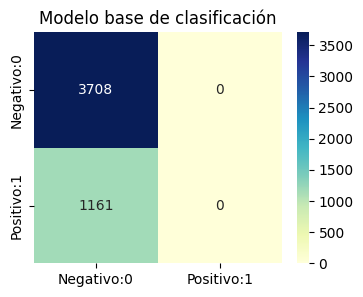

In [ ]:
# MATRIZ DE CONFUSIÓN DEL MODELO BASE DE REGRESIÓN
cm_base_model = confusion_matrix(y_test_log, y_pred_bmc)

# PLOTEO MATRIZ DE CONFUSIÓN
cm_df = pd.DataFrame(cm_base_model, columns=['Negativo:0', 'Positivo:1'],
                     index=['Negativo:0', 'Positivo:1'])
plt.figure(figsize=(4, 3))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Modelo base de clasificación'); plt.show()

-  Para un modelo base en un problema de clasificación se utiliza la moda de la variable objetivo como la predicción.

-  Como se puede observar en las métricas de precisión, recall y f1-score, el modelo base predice la clase más frecuente (moda) en el conjunto de datos de entrenamiento.

-  Esto significa que el modelo base tiene un desempeño aceptable en la clase mayoritaria, pero no predice la clase minoritaria en absoluto.
---

### **Optimización de hipeparámetros**

**Optimización en regresión**

In [ ]:
# MÉTRICAS DE LA REGRESIÓN LINEAL
metrics_df

,LR,RIDGE,LASSO,E.NET,GD,GD-STC,GD-MB
R2_TRAIN,0.222,0.222,0.221,0.221,0.219,0.162,0.242
R2_TEST,0.25,0.25,0.248,0.248,0.198,0.136,0.218
MSE,35.698,35.714,35.795,35.819,37.217,39.894,36.106
RMSE,5.975,5.976,5.983,5.985,6.101,6.316,6.009
MAE,2.767,2.765,2.767,2.74,2.882,3.146,2.779


Si recordamos la tabla de comparación de métricas de la regresión lineal, las peores puntuaciones se dieron con gradiente descendiente. Se podría optimizar el ratio de aprendizaje y la cantidad de épocas y obtener un mejor desempeño.

La librería de Scikit-Learn ya tiene implementada una clase para el gradiente descendiente estocástico, la cual podemos utilizar para intentar optimizar con el método grid search. En esta clase los parámetros eta0(lr) y max_iter(épocas) son los objetivos a optimizar.

Como los hiperparámetros son pocos podemos usar una búsqueda en grilla y encontrar la combinación óptima en un tiempo computacional muy pequeño.

In [ ]:
# INICIALIZAR EL MODELO SGDRegressor
sgd_regressor = SGDRegressor(random_state=42)

# PARÁMETROS A AJUSTAR
param_grid = {
    'eta0': [0.001, 0.01, 0.1, 0.02, 0.5, 1],
    'max_iter': [25,50,100,200,250]
}

# INICIALIZAR GridSearchCV
grid_search_sgd = GridSearchCV(sgd_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# BÚSQUEDA DE LOS MEJORES HIPERPARÁMETROS
grid_search_sgd.fit(x_train_scaled, y_train)

# MEJOR MODELO OBTENIDO
best_sgd_model = grid_search_sgd.best_estimator_

# PREDICCIONES DEL MEJOR MODELO HALLADO
y_pred_sgd = best_sgd_model.predict(x_test_scaled)
y_pred_sgd_train = best_sgd_model.predict(x_train_scaled)

print("Mejores parámetros:", grid_search_sgd.best_params_)

Mejores parámetros: {'eta0': 0.001, 'max_iter': 100}


In [ ]:
# CALCULAR MÉTRICAS
mse_sgd = mean_squared_error(y_test, y_pred_sgd).round(3)
rmse_sgd = mean_squared_error(y_test, y_pred_sgd, squared=False).round(3)
mae_sgd = mean_absolute_error(y_test, y_pred_sgd).round(3)
r2_sgd_test = r2_score(y_test, y_pred_sgd).round(3)
r2_sgd_train = r2_score(y_train, y_pred_sgd_train).round(3)

# AGREGAR AL DF Y COMPARAR
metrics_df['GD-OPT.'] = [r2_sgd_train,r2_sgd_test,mse_sgd,rmse_sgd,mae_sgd]
metrics_df

,LR,RIDGE,LASSO,E.NET,GD,GD-STC,GD-MB,GD-OPT.
R2_TRAIN,0.222,0.222,0.221,0.221,0.219,0.162,0.242,0.221
R2_TEST,0.25,0.25,0.248,0.248,0.198,0.136,0.218,0.248
MSE,35.698,35.714,35.795,35.819,37.217,39.894,36.106,35.824
RMSE,5.975,5.976,5.983,5.985,6.101,6.316,6.009,5.985
MAE,2.767,2.765,2.767,2.74,2.882,3.146,2.779,2.763


Despues de realizar la búsqueda de mejores hiperáparametros concluimos con un lr de 0,001 y un cantidad de 100 iteraciones como hiperparámetros óptimos.

Al reentrenar el modelo con los mejores hiperparámetros obtuvimos una mejora significativa en los coeficientes de determinación y demás métricas. Con estas mejoras de hiperparámetros el modelo de descenso por el gradiente (estocástico) alcanzó un desempeño similar al de la regresión lineal estandar y las regularizadas L1, L2 y ElasticNet.

**Optimización en clasificación**

In [ ]:
# MÉTRICAS DE LA REGRESIÓN LOGÍSTICA (umbral = 0.5)
df_tst

,precision,recall,f1-score,support
0.0,0.92,0.81,0.86,3708.0
1.0,0.56,0.76,0.64,1161.0
macro avg,0.74,0.79,0.75,4869.0
weighted avg,0.83,0.80,0.81,4869.0


Para las métricas obtenidas de la regresión logística está claro que en la clase minoritaria son relativamente malas en comparación a la otra clase. En este caso, se pueden optimizar un par de hiperparámetros que no fueron considerados previamente, como los pesos de la penalización, los algoritmos de regularización, o la cantidad de iteraciones.

En este caso se utliza búsqueda por grilla para encontrar la mejor combinación de hiperparámetros.

In [ ]:
# INICIALIZAR MODELO DE CLASIFICACIÓN RandomForestClassifier
classification_model1 = LogisticRegression()

# PARÁMETROS A AJUSTAR
scores = ['precision', 'recall', 'f1', 'accuracy']
tuned_parameters = [
    {"class_weight": [None, 'balanced'], "C": [0.0001, 0.001, 0.01],
     "solver": ['liblinear', 'newton-cg'],
     "max_iter": [50, 80, 100]}
]

# INICIALIZAR GridSearchCV
grid_search = GridSearchCV(classification_model1, tuned_parameters, scoring=scores, refit='f1')

# BÚSQUEDA DE LOS MEJORES HIPERPARÁMETROS
grid_search.fit(x_train_log_scaled, y_train_log.ravel())

# MEJOR MODELO OBTENIDO
best_lreg_model = grid_search.best_estimator_

# PREDICCIONES DEL MEJOR MODELO HALLADO
y_pred_lreg = best_lreg_model.predict(x_test_log_scaled)

print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 50, 'solver': 'newton-cg'}


In [ ]:
# REPORTE DE CLASIFICACIÓN
opt_report_lreg = classification_report(y_test_log, y_pred_lreg, output_dict=True)
opt_report_lreg.pop('accuracy')
opt_report_lreg = round(pd.DataFrame(opt_report_lreg).transpose(),2); opt_report_lreg

,precision,recall,f1-score,support
0.0,0.91,0.80,0.85,3708.0
1.0,0.53,0.73,0.62,1161.0
macro avg,0.72,0.77,0.73,4869.0
weighted avg,0.82,0.78,0.79,4869.0


Luego de realizar la búsqueda de mejores hiperparámetros en regresión logística utilizando una búsqueda por grilla y variando el puntuador del reajuste, no se logró mejorar las métricas del modelo.

---




Se puede usar otro modelo como un clasificador de árbol de decisiones y ver que sucede. En este caso la cantidad de hiperparámetros a optimizar es mayor y el tiempo de realizar una búsqueda por grilla sería muy alto, se opta por usar una búsqueda aleatoria la cual es muy probable que no encuentre una solución óptima.

In [ ]:
# INICIALIZAR MODELO DE CLASIFICACIÓN RandomForestClassifier
classification_model2 = RandomForestClassifier()

# PARÁMETROS A AJUSTAR
scores = ['precision', 'recall', 'f1', 'accuracy']

param_distributions = {
    'n_estimators': [10, 20, 50],
    'max_depth': [None, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [4, 6, 8, 10],
    'criterion' : ["gini", "entropy", "log_loss"],
    'class_weight' : [None, "balanced", "balanced_subsample"],
}

# INICIALIZAR RandomizedSearchCV
random_search = RandomizedSearchCV(classification_model2, param_distributions, scoring=scores, refit='recall')

# BÚSQUEDA DE LOS MEJORES HIPERPARÁMETROS
random_search.fit(x_train_log_scaled, y_train_log.ravel())

# MEJOR MODELO OBTENIDO
best_rforest_model = random_search.best_estimator_

# PREDICCIONES DEL MEJOR MODELO HALLADO
y_pred_rforest = best_rforest_model.predict(x_test_log_scaled)

print("Mejores parámetros:", random_search.best_params_)

Mejores parámetros: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 20, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}


In [ ]:
# REPORTE DE CLASIFICACIÓN
opt_report_rforest = classification_report(y_test_log, y_pred_rforest, output_dict=True)
opt_report_rforest.pop('accuracy')
opt_report_rforest = round(pd.DataFrame(opt_report_rforest).transpose(),2); opt_report_rforest

,precision,recall,f1-score,support
0.0,0.90,0.86,0.88,3708.0
1.0,0.61,0.69,0.65,1161.0
macro avg,0.76,0.78,0.76,4869.0
weighted avg,0.83,0.82,0.83,4869.0


In [ ]:
# CALCULO DE LA ROC Y EL AUC-ROC RLOG
y_prob_lreg = best_lreg_model.predict_proba(x_test_log_scaled)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test_log, y_prob_lreg)
roc_auc_log = roc_auc_score(y_test_log, y_prob_lreg)
# MATRIZ DE CONFUSIÓN LOG
conf_matrix = confusion_matrix(y_test_log, y_pred_lreg)

# CALCULO DE LA ROC Y EL AUC-ROC RFOREST
y_prob_rforest = best_rforest_model.predict_proba(x_test_log_scaled)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test_log, y_prob_rforest)
roc_auc_rf = roc_auc_score(y_test_log, y_prob_rforest)
# MATRIZ DE CONFUSIÓN RFOREST
conf_matrix = confusion_matrix(y_test_log, y_pred_rforest)

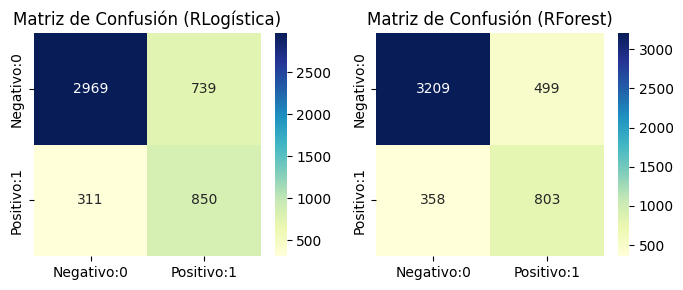

In [ ]:
# PLOTEAR MATRICES DE CONFUSIÓN
evaluate_model(y_test_log, y_pred_lreg, y_test_log, y_pred_rforest, ['RLogística','RForest'], figsize=(7,3))

**Comparación entre modelos optimizados con respecto al modeo por defecto definido originalmente.**

-   En el caso de la regresión logística, hubo un aumento de FP y FN.
-   En el otro caso, disminuyeron notablemente los FN, pero aumentaron los FP considerablemente.

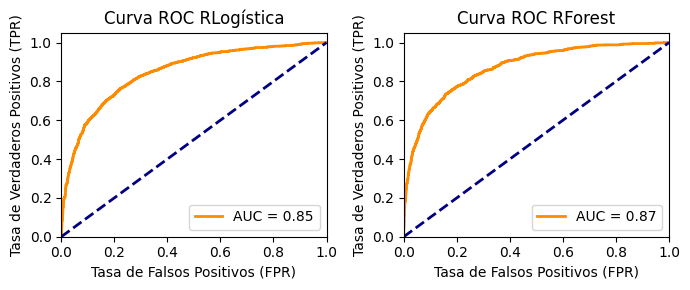

In [ ]:
plt.figure(figsize=(7, 3))
# CURVA ROC PARA LA REGRESIÓN LOGÍSTICA
plt.subplot(121)
plot_roc_curve(fpr_log, tpr_log, roc_auc_log, 'Curva ROC RLogística')

# CURVA ROC PARA RANDOM FOREST
plt.subplot(122)
plot_roc_curve(fpr_rf, tpr_rf, roc_auc_rf, 'Curva ROC RForest')

plt.tight_layout()
plt.show()


En el caso de la curva roc el puntaje del auc no varió significativamente en los modelos optimizados con respecto al sin optimizar, esto significa que todos estos modeos son capaces de diferenciar decentemente una clase de la otra.

**Conclusión:**

En el caso de la regresión lineal, la optimización de los hiperparámetros del descenso de gradiente permitió igualar el desempeño del resto de los modelos, aunque no fue posible superarlos.

Para la clasificación binaria, la optimización de la regresión logística mediante una búsqueda en grilla no logró aumentar la tasa de verdaderos positivos; por el contrario, incrementó los falsos positivos.

En cambio, la optimización con un random forest aumentó la tasa de verdaderos negativos, pero la clase minoritaria experimentó un empeoramiento. Cabe destacar que en este caso la búsqueda de hiperparámetros se realizó con un método aleatorio.

A pesar de estas optimizaciones, los modelos de regresión y clasificación siguen siendo demasiado simples para el problema de la predicción de lluvias.

## **Explicabilidad SHAP**





### **Interpretabilidad local regresión**

In [ ]:
# NOMBRE DE LAS CARACTERÍSTICAS
feature_names_reg = x_train.columns.values

# CREAR UN OBJETO SHAP
lr_explainer = shap.LinearExplainer(lr_model, x_train_scaled, feature_names=feature_names_reg)

# CALCULAR LOS VALORES SHAP PARA EL CONJUNTO DE PRUEBA
lr_shap_values = lr_explainer.shap_values(x_test_scaled)

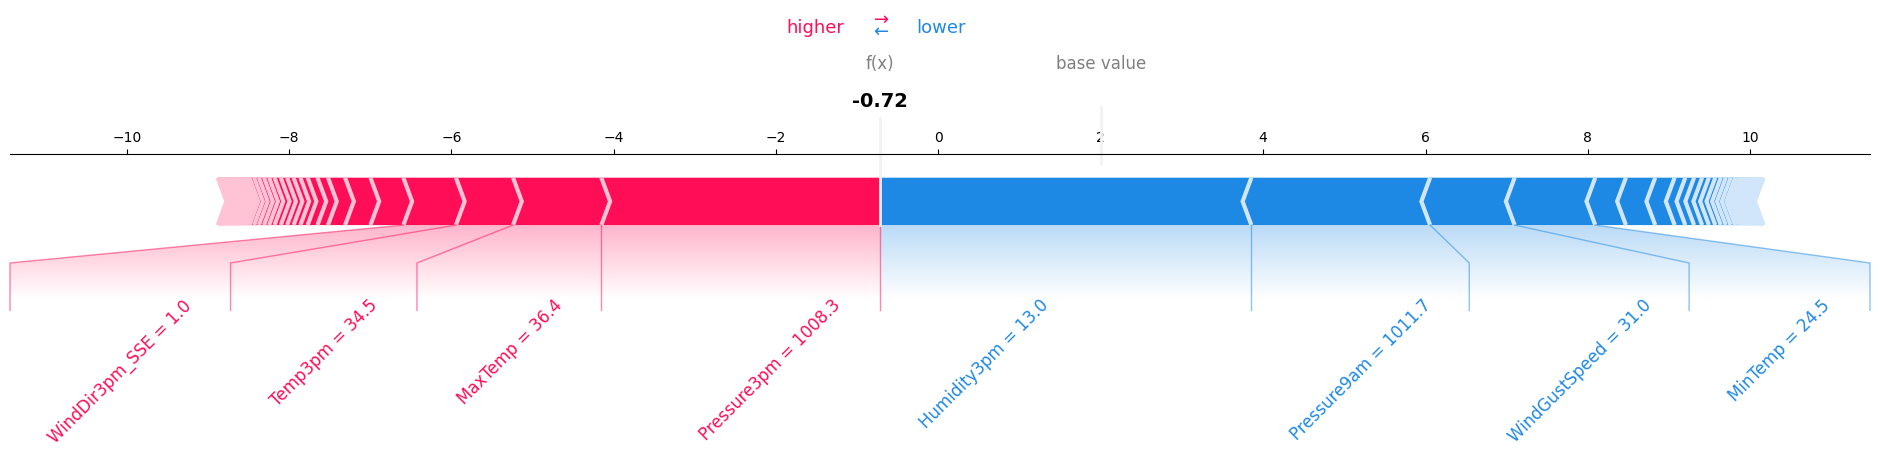

In [ ]:
# NRO DE REGISTRO
index=0

# PLOT SHAP
shap.force_plot(lr_explainer.expected_value, lr_shap_values[index], x_test.iloc[index],
                feature_names=feature_names_reg, matplotlib=True, figsize=(24, 4),
                text_rotation=45)

In [ ]:
# EXPLICACIÓN SHAP A NIVEL LOCAL
local_explanation = shap.Explanation(values=lr_shap_values[index], base_values=lr_explainer.expected_value, feature_names=feature_names_reg)

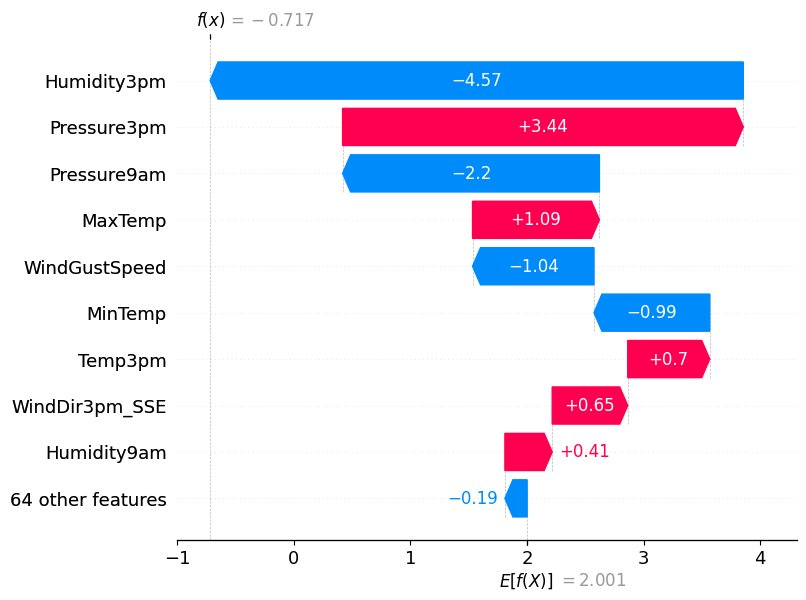

In [ ]:
shap.plots.waterfall(local_explanation)

**En estos dos gráficos expuestos se pueden ver los pesos que tiene cada una de las variables para el registro seleccionado.**

-  La humedad a las 3pm, la presión a las 9am, la velocidad del viento y la temperatura mínima, son las variables principales que disminuyen el valor de la variable objetivo.

-  Por otro lado, la presión a las 3pm, la temperatura máxima, la temperatura a las 3pm, la dirección SSE de viento a las 3m y la humedad a las 9am son las variables principales con mayor peso que aumentan el valor de la variable objetivo.

###**Interpretabilidad global regresión**

In [ ]:
# EXPLICACIÓN SHAP A NIVEL GLOBAL
global_explanation = shap.Explanation(values=lr_shap_values, base_values=lr_explainer.expected_value, feature_names=feature_names_reg, data=x_test)

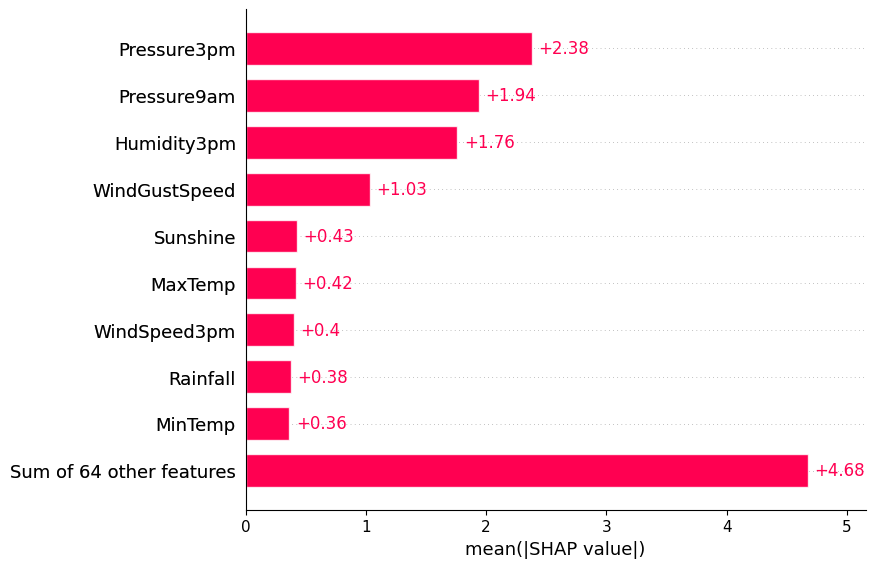

In [ ]:
shap.plots.bar(global_explanation)

A nivel global vemos las ocho variables principales con los mayores pesos sobre la variable objetivo.

La presion a las 3pm, la presión a las 9am, la humedad a las 3pm y la velocidad del viento son las que mayor peso acumulan.

Algo que se puede notar es que coincide la importancia de la presión a las 3pm y la temperatura máxima en el registro local seleccionado y el peso de estas a nivel global.

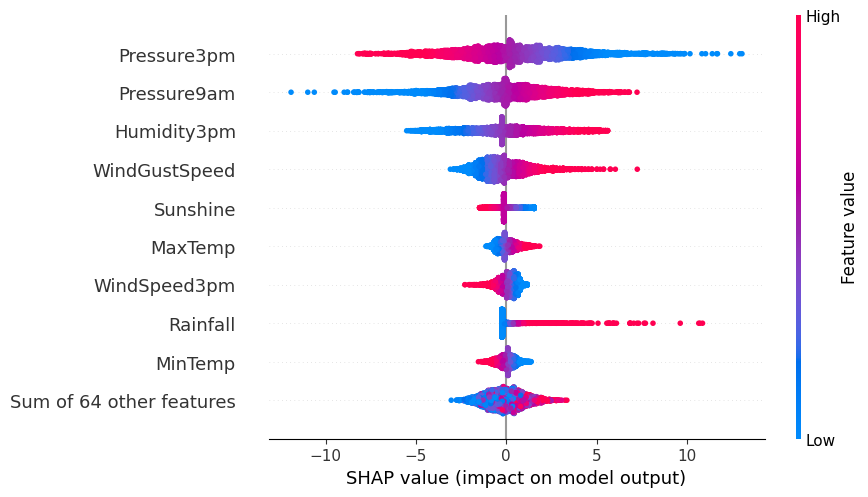

In [ ]:
shap.plots.beeswarm(global_explanation)

En este plot se puede ver que las variables más influyentes a nivel global son la presión a las 3pm y a las 9am, y la humedad a las 3pm.

En el caso de la presión, altas presiones incrementan la probabilidad de lluvia, mientras que bajas presiones la disminuyen, y para la humedad a las 3pm, aumenta significativamente la probabilidad de lluvia.

### **Interpretabilidad local clasificación**

In [ ]:
# NOMBRE DE LAS CARACTERÍSTICAS
feature_names_log = x_train_log.columns.values

# CREAR OBJETO EXPLAINER
log_explainer = shap.LinearExplainer(logistic_model, x_train_log_scaled, feature_names=feature_names_log)

# CALCULAR VALORES SHAP PARA EL CONJUNTO DE TEST
log_shap_values = explainer.shap_values(x_test_log_scaled)

In [ ]:
# EXPLICACIÓN SHAP A NIVEL LOCAL
log_local_explanation = shap.Explanation(values=log_shap_values[50],
                                     base_values=log_explainer.expected_value,
                                     feature_names=feature_names_log)

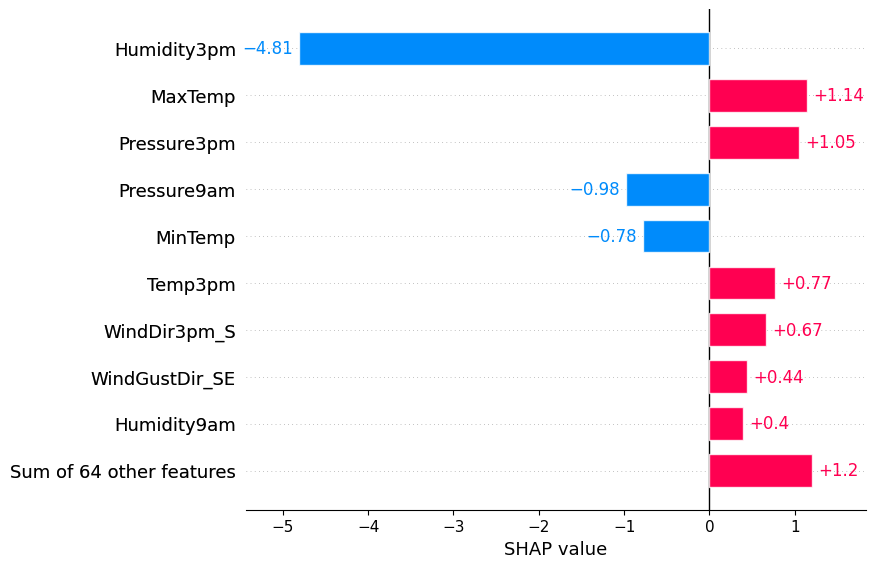

In [ ]:
shap.plots.bar(log_local_explanation)

En este caso el grafico de los valores SHAP para un registro particular, casi en su mayoría, las variables tiene un peso importante en aumentar las probabilidades de que llueva al dia siguiente.

Pero también vemos que la variable con mayor peso, humedad a las 3pm, disminuye las probabilidades de lluvia con un peso muy similar al que acumulan las que aumenta las probabilidades.

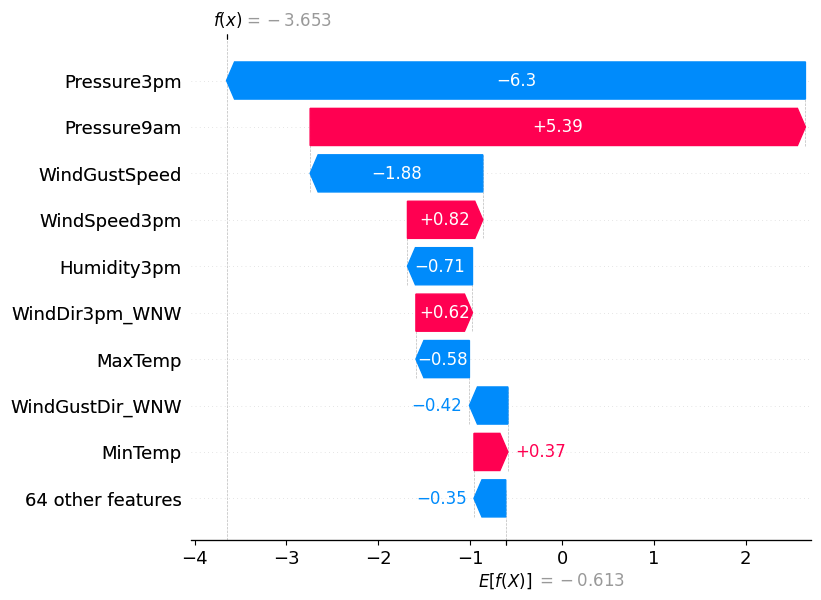

In [ ]:
log_local_explanation = shap.Explanation(values=log_shap_values[3983],
                                     base_values=log_explainer.expected_value,
                                     feature_names=feature_names_log)

shap.plots.waterfall(log_local_explanation)

Si observamos otro registro al azar podemos ver como las variables varían los pesos, pero mayormente las direcciones del viento, la presión o la humedad suelen ser muy importantes. Particularmente las direcciones del viento suelen variar, pero probablemente se deba a la ubicación de la localidad del registro observado.

Este registro es muy particular porque muestra como una misma variable como la humedad, medida en diferentes horas del día tiene pesos opuestos en las prbabilidades de lluvia.

###**Interpretabilidad global clasificación**

In [ ]:
# EXPLICACIÓN SHAP A NIVEL GLOBAL
log_global_explanation = shap.Explanation(values=log_shap_values,
                                      base_values=log_explainer.expected_value,
                                      feature_names=feature_names_log,
                                      data=x_test_log_scaled)

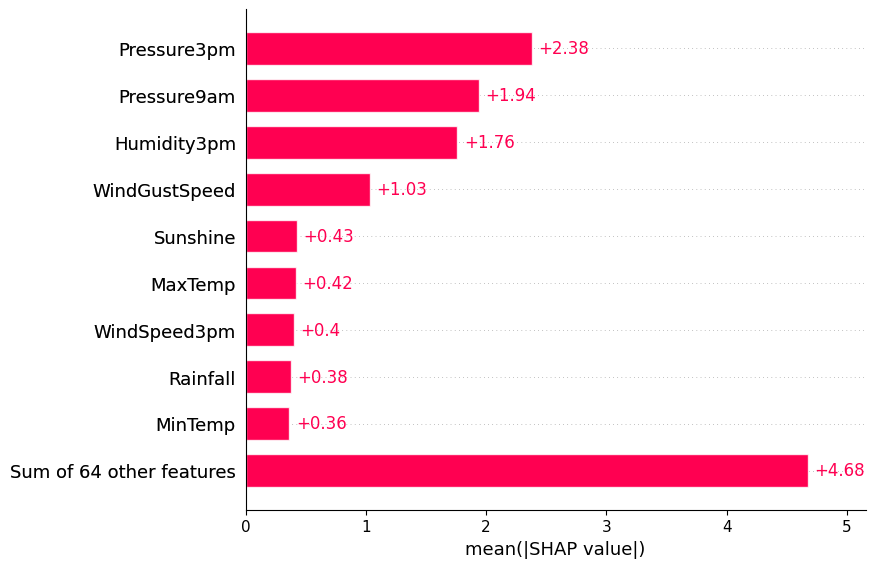

In [ ]:
shap.plots.bar(log_global_explanation)

Al observar los pesos SHAP de las variables a nivel global vemos nuevamente como la presión, la humedad y la velocidad del viento son las características con mayor peso que aumentan las probabilidades de lluvia al día siguiente.

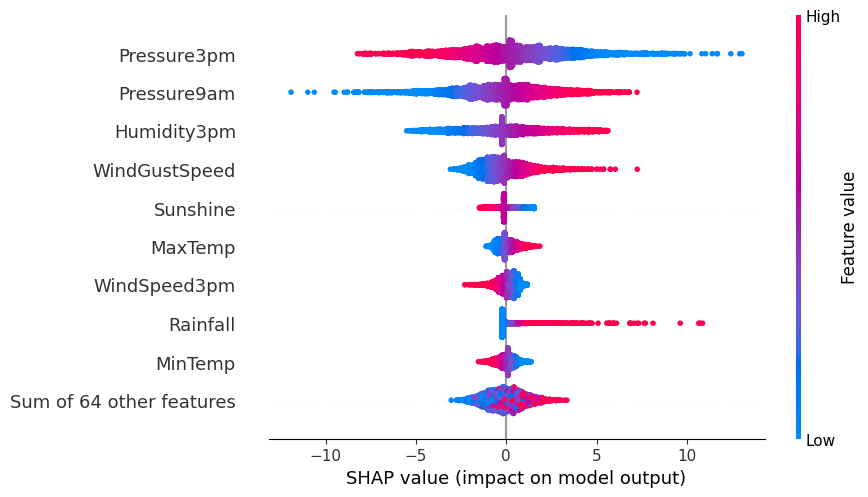

In [ ]:
shap.plots.beeswarm(log_global_explanation)

Acá podemos ver que las variables más importantes para predecir si llueve al día siguiente son las presiones a las 3pm y 9am, la humedad a las 3pm, y la velocidad de las ráfagas de viento.

En general, altos valores de humedad y lluvia aumentan la probabilidad de lluvia al día siguiente, mientras que altas velocidades de viento disminuyen la probabilidad de lluvia.

---

**Conclusión:**

A nivel local y global tanto para el modelo de regresión y clasificación, las variables de presión a las 9am y 3pm, la humedad a las 3pm y la velocidad del viento son las que tienen los pesos SHAP más significativos, aumentando las probabilidades y cantidades (mm) de lluvia al día siguiente.

Esta importancia de las variables tiene logica ya que nuestras variables a predecir tienen un mismo significado, más de 1 mm llueve, de lo contrario no llueve.

---